In [1]:
import geopy
from geopy.extra.rate_limiter import RateLimiter


import pandas as pd
import numpy as np
import geopandas as gpd

from matplotlib import pyplot as plt
import shapely

%matplotlib inline

import contextily as ctx
import requests
import plotly.express as px
from zipfile import ZipFile
import json
import random
import os, urllib
import seaborn as sbn

#from tqdm.auto import tqdm, trange
from tqdm import tqdm, trange
tqdm.pandas()

from geopy_nominatim_wrapper import NominatimWrapper
from geopy_bestaddress import BestAddress
from geopy_pelias import Pelias
from geopy_ngipelias import NGIPelias


from credentials import (here_api_key, 
                         bing_api_key, 
                         mapbox_api_key, 
                         tomtom_api_key, 
                         google_api_key, 
                         best_client_id, best_client_secret, best_hostname)



fig_path = "output/geocoding/figs"
data_dir = "data/geocoding"
output_dir="output/geocoding/"
# from fpdf import FPDF 

In [2]:
# dataset = "rrn_1000"
dataset = "kbo_1000"
# dataset = "best_1000"
# dataset = "best2_1000"
# dataset = "rep_1000"
# dataset = "resto_1000"

In [3]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

In [4]:
def_figsize = (10,8)

In [5]:
os.makedirs(f"{output_dir}/geocoded_data/", exist_ok=True)
os.makedirs(f"{output_dir}/reports/", exist_ok=True)
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


In [6]:
def add_basemap(ax, zoom='auto'):
    """
    Add a basemap on a plot. Tries first default (Stamen) basemap. If errors, tries OpenStreetMap.Mapnik
    
    Parameters
    ----------
    ax: matplotlib axes
    
    Returns
    -------
        None
    """

    try: 
        ctx.add_basemap(ax, zoom=zoom)
    except requests.HTTPError:
        print("Default basemap doesn't work...")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)

In [7]:
def set_optimal_limits(ax, df):
    """
    Adapt xlim/ylim to a GeoDataFrame point plot to avoid plot to be too wide when 
    points are horizontally aligned, and to narrow when points are vertically aligned

    Usage : 
    
    ax = df.plot()
    set_optimal_limits(ax, df)
    
    Parameters
    ----------
    ax: AxesSubplot
       plot to resize
    df: GeoDataFrame
       data to be plotted

    Returns
    -------
        None
    """
    
    plot_ratio = 1.5 # optimal ratio between "one horizontal degree" and "one vertical degree". It depends of the CRS. 
                     # For "polar" CRS, it may also depend of the place on the globe

    minimal_width=200
   
    margins = 1.1 # Avoid having dots on edges of the plot
    

    # Compute dimension of the data
    xmin, ymin, xmax, ymax = df.total_bounds
    height = (ymax - ymin) 
    width = (xmax - xmin)
    
    opt_height = max(height, width / plot_ratio, minimal_width / plot_ratio)
    opt_width  = max(width , height*plot_ratio, minimal_width)
    
#     print(xmin, ymin, xmax, ymax)
#     print(width, height, opt_width, opt_height)
    # If plot is too narrow, increase xmin. If plot is too wide, increase ylim

    if opt_height > height :
        ymid = (ymax+ymin)/2
        mid_height = opt_height * margins / 2
        ax.set_ylim(ymid - mid_height, ymid + mid_height)
    if opt_width > width:
        xmid = (xmax+xmin)/2
        mid_width = opt_width* margins/2
        ax.set_xlim(xmid - mid_width, xmid + mid_width)

In [8]:
def pdf_savefig():
    try: 
        pdf.savefig(bbox_inches='tight')
    except AttributeError:
        print("PDF probably closed")

In [9]:
# plot_address(geocoded_data, geocoded_data.iloc[5].address)

# Prepare geocoders

In [10]:
def get_precision(record):
    
    precision_field= {
        "nominatim": "class",
        "nominatim_loc": "class",
        "nominatim_wrapper": ("metadata", "placeRank"),
#         "nominatim_wrapper2": "place_rank",
        "here": "MatchLevel",
        "photon": ("properties", "type"),
        "bing": "entityType",
        "mapbox": ("properties", "accuracy"),
        "tomtom": "type",
        "trillium": "match_level",
        "google":("geometry", "location_type"),
        "bestaddress": "precision",
        "lpost_bestaddress": "precision"
    }
    
    label_mapping = {
        "nominatim": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
                      
                      
        "nominatim_loc": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
        
        "nominatim_wrapper": {"30": "building", 
                              "27": "street",
                              "26": "street",
                              "25": "city",
                              "22": "city",
                              "21": "city",
                              "20": "city",
                              "19": "city",
                              "18": "city",
                              "16": "city",
                              "14": "city"},

        "here": {"houseNumber": "building",
                "street": "street",
                "city": "city",
                "postalCode": "city"},
        "photon": {
            "house": "building",
            "locality": "city",
            "district": "city",
            "city": "city",
            "street": "street"},
        "bing": { "Address": "building",
                  "RoadBlock": "street",
                 "PopulatedPlace": "city",
                 "Postcode1": "city",
                 "CountryRegion": "country"
                },
        "mapbox": {"rooftop": "building",
                   "point": "building",
                   "interpolated": "building",
                  "street": "street"},
        
        "tomtom": {"Point Address": "building",
                  "Street": "street",
                  "Address Range": "street",
                  "Cross Street": "street",
                  "Geography": "city"},
        "trillium": {0:"building",
                      2: "city",
                      3: "street"},
        "google" : {
            "ROOFTOP": "building",
            "RANGE_INTERPOLATED": "building",
            "GEOMETRIC_CENTER": "street",
            "APPROXIMATE": "city"
        },
        "bestaddress":{
            "building": "building",
            "street":"street",
            "country": "country",
            "city":"city"
        },
        "lpost_bestaddress":{
        "building": "building",
        "street":"street",
        "country": "country"
        }
    }
    
    if "pelias" in record.geocoder:
        
        if record.location.point == geopy.Point(0,0):
            return "country"
        
        raw_label = record.location.raw["properties"]
        
        if raw_label["match_type"] == "exact" and 'housenumber' in raw_label:
            return "building"
        if "street" in raw_label:
            return "street"
        if "region" in raw_label:
            return "city"
        return "country"
        
    
    try: 
        f = precision_field[record.geocoder]
        mapper = label_mapping[record.geocoder]
        if isinstance(f, str):
            raw_label = record.location.raw[f]
        else: 
            raw_label =  record.location.raw[f[0]][f[1]]
        return mapper[raw_label] if raw_label in mapper else f"[UNKNOWN - {raw_label}]"
    except KeyError: 
        if record.geocoder == "mapbox":
            return "city"
        return "[UNKNOWN]"
    
    

In [11]:
geocoders = {}

In [12]:
from geopy.geocoders import Nominatim
geocoders['nominatim'] = Nominatim(user_agent="smalsresearch", domain="172.27.0.64:8080", scheme="http", timeout=1000)
# geocoders['nominatim'] = Nominatim(user_agent="smalsresearch")


In [13]:
geocoders['nominatim_wrapper'] = NominatimWrapper(user_agent="smalsresearch", scheme="http", timeout=1000, domain="172.27.0.64:5000")

In [14]:
geocoders['bestaddress'] = BestAddress(user_agent="smalsresearch", scheme="https", timeout=1000, 
                                       client_id=best_client_id, client_secret=best_client_secret,
                                       domain=best_hostname,
                                       verbose=False
                                      )

In [15]:
# from geopy.geocoders import Pelias
geocoders['pelias']        = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)
geocoders['pelias_struct'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)


In [16]:
geocoders['ngi_pelias_basic'] = NGIPelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
#                                     mode="simple")
                                    mode="basic")


In [17]:
geocoders['ngi_pelias_simple'] = NGIPelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
                                    mode="simple")


In [18]:
geocoders['ngi_pelias'] = NGIPelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
#                                     mode="simple")
                                    mode="advanced")


In [19]:
from geopy.geocoders import Here
geocoders['here'] = Here(apikey=here_api_key)

In [20]:
from geopy.geocoders import Bing
geocoders['bing'] = Bing(api_key=bing_api_key)

In [21]:
from geopy.geocoders import Photon
# geocoders['photon'] = Photon(domain="photon.komoot.io")

geocoders['photon'] = Photon(domain="127.0.0.1:2322", scheme="http")

# geocoders['photon'].geocode("Avenue Fonsny 20, 1060 Bruxelles").raw

In [22]:
from geopy.geocoders import MapBox
geocoders['mapbox'] = MapBox(api_key=mapbox_api_key)

In [23]:
from geopy.geocoders import TomTom
geocoders['tomtom'] =TomTom(api_key=tomtom_api_key)

In [24]:
from geopy.geocoders import GoogleV3
geocoders["google"] = GoogleV3(api_key=google_api_key)

In [25]:
from matplotlib.backends.backend_pdf import PdfPages


# Load data


In [26]:
data = pd.read_csv(f"{data_dir}/{dataset}.csv.gz", dtype=str)

mandatory_columns = ["street", "housenumber", "postcode", "city"]
for f in mandatory_columns:
    assert f in data, f"Field {f} is mandatory !!"


In [27]:
data["address"] = data.street.fillna("")+", "+data.housenumber.fillna("")+", "+data.postcode+" "+data.city+", Belgique"
data

street housenumber postcode                city  \
0       Dendermondsesteenweg         200     2830          Willebroek   
1        Boulevard du Régent          47     1000           Bruxelles   
2                   Hauwaart          44     9700          Oudenaarde   
3            Bruynebosstraat          40     3511             Hasselt   
4          Steenwinkelstraat         583     2627             Schelle   
..                       ...         ...      ...                 ...   
995          Route de Marche          43     6940              Durbuy   
996  Godfried van Leuvenlaan           8     1600  Sint-Pieters-Leeuw   
997               Valleilaan          83     3290               Diest   
998              Venusstraat           2     2000           Antwerpen   
999             Voie Jocquée          10     6830            Bouillon   

                                               address  
0    Dendermondsesteenweg, 200, 2830 Willebroek, Be...  
1    Boulevard du Régent, 47, 1000 Bruxelles, Belgique  
2              Hauwaart, 44, 9700 Oudenaarde, Belgique  
3          Bruynebosstraat, 40, 3511 Hasselt, Belgique  
4       Steenwinkelstraat, 583, 2627 Schelle, Belgique  
..                                                 ...  
995         Route de Marche, 43, 6940 Durbuy, Belgique  
996  Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...  
997               Valleilaan, 83, 3290 Diest, Belgique  
998           Venusstraat, 2, 2000 Antwerpen, Belgique  
999          Voie Jocquée, 10, 6830 Bouillon, Belgique  

[1000 rows x 5 columns]

In [28]:
data = data.reset_index().rename(columns={"index": "reference_key"})

In [29]:
pdf = PdfPages(f"output/geocoding/reports/report_{dataset}.pdf")

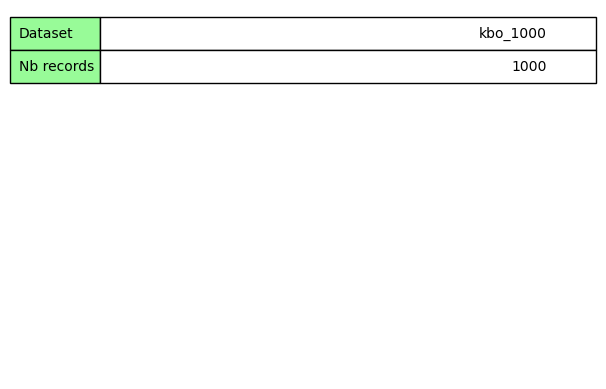

In [30]:
metadata= [["Dataset", dataset],
          ["Nb records", data.shape[0]]]


fig, ax =plt.subplots()
ax.set_axis_off() 
tbl = ax.table(cellText = [ r[1:] for r in metadata],
         rowLabels = [r[0] for r in metadata],
         rowColours = ["palegreen"] * len(metadata),
        loc="upper left")
tbl.scale(1,2)
pdf_savefig()

# Geocode

In [31]:
try: 
    no_res_timing = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
except FileNotFoundError: 
    no_res_timing = pd.DataFrame(columns =["address", "geocoder", "duration"] )

In [32]:
import datetime
#no_res_timing ={}
def geocode_and_timeit(geocoder, addr):
    global no_res_timing
    start = datetime.datetime.now()
    res = geocoder(addr)
    if res:
        res.raw.update({"duration": datetime.datetime.now()-start})
    else: 
        geocoder_name = list(filter(lambda y: y[1] == geocoder.__self__ , [(x, geocoders[x]) for x in geocoders]))[0][0]
        
        no_res_timing = pd.concat([no_res_timing, pd.DataFrame([{"address":  addr,
                                              "duration": (datetime.datetime.now()-start).total_seconds(), 
                                              "geocoder": geocoder_name}])])
    return res

In [33]:
geocoded_data_r = [] #gpd.GeoDataFrame()
coders=["nominatim_wrapper", "nominatim", "here", "bing", "mapbox", "tomtom", "google", "bestaddress", 
        "ngi_pelias"]
coders=["nominatim_wrapper", "nominatim", "here", "bing", "google", "tomtom", "ngi_pelias"]

# coders=[ "bing", "google", "here", "tomtom", "nominatim", "nominatim_wrapper", "pelias", "ngi_pelias"]
coders=[ "bing", "google", "here", "tomtom", "nominatim", "pelias", "photon"]

coders=["here", "bing", "tomtom", "google", "nominatim_wrapper", "nominatim"]
# coders=["here", "bing", "tomtom", "google", "nominatim_loc"]
# coders =["nominatim_wrapper", "nominatim_loc", "pelias", "bestaddress", "pelias_plus"]

# from_file = ["nominatim", "here", "bing", "tomtom", "google"]
from_file = coders

# coders =["pelias", "pelias_struct", "ngi_pelias_basic", "ngi_pelias_simple", "ngi_pelias"]
# from_file=["pelias", "pelias_struct", ] 
# from_file = coders

# coders =["photon"]#, "pelias", "pelias_struct"]#, "ngi_pelias_basic", "ngi_pelias_simple"]
# from_file=[] 


delay={"mapbox":0.5, "nominatim_wrapper":0.01,  "nominatim":0.01, "lpost_bestaddress": 0.01, "google":0.5, "tomtom": 0.4,
      "ngi_pelias": 0.02, "pelias": 0.02 
      }



for coder in coders: #geocoders:
    print(coder)
    
    if coder in from_file:
        print("Load from local file...")
        g_data = pd.read_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    else: 
        
        # Erase no-res timing for this coder for any previous run
        no_res_timing = no_res_timing[no_res_timing.geocoder != coder]
        
        g = geocoders[coder]
        g.geocode_timeit = lambda x: geocode_and_timeit(g.geocode, x)
        geocode = RateLimiter(g.geocode_timeit, min_delay_seconds=delay[coder] if coder in delay else 0.2)

        if coder in ["bestaddress", "ngi_pelias", 'ngi_pelias_basic', 'ngi_pelias_simple']: # structured addresses
            g_data = data.assign(location=data[["street", "housenumber", "postcode", "city"]].apply(dict, axis=1).progress_apply(geocode)).assign(geocoder=coder)
        elif coder in ["pelias_struct"]: # structured pelias
            g_data = data.assign(location=data.assign(address = data["street"]+", "+data["housenumber"]).\
                          rename(columns={"postcode": "postalcode", "city": "locality"})[["address", "postalcode", "locality"]].apply(dict, axis=1).progress_apply(geocode)).assign(geocoder=coder)

        else: 
            g_data = data.assign(location=(data['address'].str.replace("/", "%2F") if coder=="tomtom" else data['address']).progress_apply(geocode)).assign(geocoder=coder)
#             g_data = data.assign(location=data['address'].progress_apply(geocode)).assign(geocoder=coder)
        g_data.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    
    geocoded_data_r.append(g_data)
    display(g_data)
    

here
Load from local file...


reference_key                   street housenumber postcode  \
0                0     Dendermondsesteenweg         200     2830   
1                1      Boulevard du Régent          47     1000   
2                2                 Hauwaart          44     9700   
3                3          Bruynebosstraat          40     3511   
4                4        Steenwinkelstraat         583     2627   
..             ...                      ...         ...      ...   
995            995          Route de Marche          43     6940   
996            996  Godfried van Leuvenlaan           8     1600   
997            997               Valleilaan          83     3290   
998            998              Venusstraat           2     2000   
999            999             Voie Jocquée          10     6830   

                   city                                            address  \
0            Willebroek  Dendermondsesteenweg, 200, 2830 Willebroek, Be...   
1             Bruxelles  Boulevard du Régent, 47, 1000 Bruxelles, Belgique   
2            Oudenaarde            Hauwaart, 44, 9700 Oudenaarde, Belgique   
3               Hasselt        Bruynebosstraat, 40, 3511 Hasselt, Belgique   
4               Schelle     Steenwinkelstraat, 583, 2627 Schelle, Belgique   
..                  ...                                                ...   
995              Durbuy         Route de Marche, 43, 6940 Durbuy, Belgique   
996  Sint-Pieters-Leeuw  Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...   
997               Diest               Valleilaan, 83, 3290 Diest, Belgique   
998           Antwerpen           Venusstraat, 2, 2000 Antwerpen, Belgique   
999            Bouillon          Voie Jocquée, 10, 6830 Bouillon, Belgique   

                                              location geocoder  
0    (Dendermondsesteenweg 200, 2830 Willebroek, Be...     here  
1    (Boulevard du Régent 47, 1000 Bruxelles, Belgi...     here  
2    (Hauwaart 44, 9700 Oudenaarde, België, Oudenaa...     here  
3    (Bruynebosstraat 40, 3511 Hasselt, België, Has...     here  
4    (Steenwinkelstraat 583, 2627 Schelle, België, ...     here  
..                                                 ...      ...  
995  (Route de Marche 43, 6940 Durbuy, Belgique, Du...     here  
996  (Godfried van Leuvenlaan 8, 1600 Sint-Pieters-...     here  
997  (Valleilaan 83, 3290 Diest, België, Diest, Vla...     here  
998  (Venusstraat 2, 2000 Antwerpen, België, Antwer...     here  
999  (Voie Jocquée 10, 6830 Bouillon, Belgique, Bou...     here  

[1000 rows x 8 columns]

bing
Load from local file...


reference_key                   street housenumber postcode  \
0                0     Dendermondsesteenweg         200     2830   
1                1      Boulevard du Régent          47     1000   
2                2                 Hauwaart          44     9700   
3                3          Bruynebosstraat          40     3511   
4                4        Steenwinkelstraat         583     2627   
..             ...                      ...         ...      ...   
995            995          Route de Marche          43     6940   
996            996  Godfried van Leuvenlaan           8     1600   
997            997               Valleilaan          83     3290   
998            998              Venusstraat           2     2000   
999            999             Voie Jocquée          10     6830   

                   city                                            address  \
0            Willebroek  Dendermondsesteenweg, 200, 2830 Willebroek, Be...   
1             Bruxelles  Boulevard du Régent, 47, 1000 Bruxelles, Belgique   
2            Oudenaarde            Hauwaart, 44, 9700 Oudenaarde, Belgique   
3               Hasselt        Bruynebosstraat, 40, 3511 Hasselt, Belgique   
4               Schelle     Steenwinkelstraat, 583, 2627 Schelle, Belgique   
..                  ...                                                ...   
995              Durbuy         Route de Marche, 43, 6940 Durbuy, Belgique   
996  Sint-Pieters-Leeuw  Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...   
997               Diest               Valleilaan, 83, 3290 Diest, Belgique   
998           Antwerpen           Venusstraat, 2, 2000 Antwerpen, Belgique   
999            Bouillon          Voie Jocquée, 10, 6830 Bouillon, Belgique   

                                              location geocoder  
0    (Dendermondsesteenweg 200, Willebroek, Flemish...     bing  
1    (Boulevard du Régent 47, Brussels, Brussels Re...     bing  
2    (Hauwaart 44, Oudenaarde, Flemish Region 9700,...     bing  
3    (Bruynebosstraat 40, Hasselt, Flemish Region 3...     bing  
4    (Steenwinkelstraat 583, Schelle, Flemish Regio...     bing  
..                                                 ...      ...  
995  (Route de Marche 43, Durbuy, Walloon Region 69...     bing  
996  (Godfried van Leuvenlaan, St-Pieters-Leeuw, Fl...     bing  
997  (Valleilaan 83, Diest, Flemish Region 3290, Be...     bing  
998  (Venusstraat 2, Antwerp, Flemish Region 2000, ...     bing  
999  (Voie Jocquée 10, Bouillon, Walloon Region 683...     bing  

[1000 rows x 8 columns]

tomtom
Load from local file...


reference_key                   street housenumber postcode  \
0                0     Dendermondsesteenweg         200     2830   
1                1      Boulevard du Régent          47     1000   
2                2                 Hauwaart          44     9700   
3                3          Bruynebosstraat          40     3511   
4                4        Steenwinkelstraat         583     2627   
..             ...                      ...         ...      ...   
995            995          Route de Marche          43     6940   
996            996  Godfried van Leuvenlaan           8     1600   
997            997               Valleilaan          83     3290   
998            998              Venusstraat           2     2000   
999            999             Voie Jocquée          10     6830   

                   city                                            address  \
0            Willebroek  Dendermondsesteenweg, 200, 2830 Willebroek, Be...   
1             Bruxelles  Boulevard du Régent, 47, 1000 Bruxelles, Belgique   
2            Oudenaarde            Hauwaart, 44, 9700 Oudenaarde, Belgique   
3               Hasselt        Bruynebosstraat, 40, 3511 Hasselt, Belgique   
4               Schelle     Steenwinkelstraat, 583, 2627 Schelle, Belgique   
..                  ...                                                ...   
995              Durbuy         Route de Marche, 43, 6940 Durbuy, Belgique   
996  Sint-Pieters-Leeuw  Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...   
997               Diest               Valleilaan, 83, 3290 Diest, Belgique   
998           Antwerpen           Venusstraat, 2, 2000 Antwerpen, Belgique   
999            Bouillon          Voie Jocquée, 10, 6830 Bouillon, Belgique   

                                              location geocoder  
0    (Dendermondsesteenweg 200, 2830 Willebroek, (5...   tomtom  
1    (Boulevard du Régent 47, 1000 Bruxelles, (50.8...   tomtom  
2    (Hauwaart 44, 9700 Oudenaarde, (50.83173, 3.66...   tomtom  
3    (Bruynebosstraat 40, 3511 Hasselt, (50.97784, ...   tomtom  
4    (Steenwinkelstraat 583, 2627 Schelle, (51.1226...   tomtom  
..                                                 ...      ...  
995  (Route de Marche 43, 6940 Durbuy, (50.34762, 5...   tomtom  
996  (Godfried van Leuvenlaan, 1600 Sint-Pieters-Le...   tomtom  
997   (Valleilaan 83, 3290 Diest, (50.98833, 5.04864))   tomtom  
998  (Venusstraat 2, 2000 Antwerpen, (51.22486, 4.4...   tomtom  
999  (Voie Jocquée 10, 6830 Bouillon, (49.7949, 5.0...   tomtom  

[1000 rows x 8 columns]

google
Load from local file...


reference_key                   street housenumber postcode  \
0                0     Dendermondsesteenweg         200     2830   
1                1      Boulevard du Régent          47     1000   
2                2                 Hauwaart          44     9700   
3                3          Bruynebosstraat          40     3511   
4                4        Steenwinkelstraat         583     2627   
..             ...                      ...         ...      ...   
995            995          Route de Marche          43     6940   
996            996  Godfried van Leuvenlaan           8     1600   
997            997               Valleilaan          83     3290   
998            998              Venusstraat           2     2000   
999            999             Voie Jocquée          10     6830   

                   city                                            address  \
0            Willebroek  Dendermondsesteenweg, 200, 2830 Willebroek, Be...   
1             Bruxelles  Boulevard du Régent, 47, 1000 Bruxelles, Belgique   
2            Oudenaarde            Hauwaart, 44, 9700 Oudenaarde, Belgique   
3               Hasselt        Bruynebosstraat, 40, 3511 Hasselt, Belgique   
4               Schelle     Steenwinkelstraat, 583, 2627 Schelle, Belgique   
..                  ...                                                ...   
995              Durbuy         Route de Marche, 43, 6940 Durbuy, Belgique   
996  Sint-Pieters-Leeuw  Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...   
997               Diest               Valleilaan, 83, 3290 Diest, Belgique   
998           Antwerpen           Venusstraat, 2, 2000 Antwerpen, Belgique   
999            Bouillon          Voie Jocquée, 10, 6830 Bouillon, Belgique   

                                              location geocoder  
0    (Dendermondsesteenweg 200, 2830 Willebroek, Be...   google  
1    (Bd du Régent 47, 1000 Bruxelles, Belgium, (50...   google  
2    (Hauwaart 44, 9700 Oudenaarde, Belgium, (50.83...   google  
3    (Bruynebosstraat 40, 3511 Hasselt, Belgium, (5...   google  
4    (Steenwinkelstraat 583, 2627 Schelle, Belgium,...   google  
..                                                 ...      ...  
995  (Rte de Marche 43, 6940 Durbuy, Belgium, (50.3...   google  
996  (Godfried Van Leuvenlaan 8, 1600 Sint-Pieters-...   google  
997  (Valleilaan 83, 3290 Diest, Belgium, (50.98836...   google  
998  (Venusstraat 2, 2000 Antwerpen, Belgium, (51.2...   google  
999  (Voie Jocquée 10, 6830 Bouillon, Belgium, (49....   google  

[1000 rows x 8 columns]

nominatim_wrapper
Load from local file...


reference_key                   street housenumber postcode  \
0                0     Dendermondsesteenweg         200     2830   
1                1      Boulevard du Régent          47     1000   
2                2                 Hauwaart          44     9700   
3                3          Bruynebosstraat          40     3511   
4                4        Steenwinkelstraat         583     2627   
..             ...                      ...         ...      ...   
995            995          Route de Marche          43     6940   
996            996  Godfried van Leuvenlaan           8     1600   
997            997               Valleilaan          83     3290   
998            998              Venusstraat           2     2000   
999            999             Voie Jocquée          10     6830   

                   city                                            address  \
0            Willebroek  Dendermondsesteenweg, 200, 2830 Willebroek, Be...   
1             Bruxelles  Boulevard du Régent, 47, 1000 Bruxelles, Belgique   
2            Oudenaarde            Hauwaart, 44, 9700 Oudenaarde, Belgique   
3               Hasselt        Bruynebosstraat, 40, 3511 Hasselt, Belgique   
4               Schelle     Steenwinkelstraat, 583, 2627 Schelle, Belgique   
..                  ...                                                ...   
995              Durbuy         Route de Marche, 43, 6940 Durbuy, Belgique   
996  Sint-Pieters-Leeuw  Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...   
997               Diest               Valleilaan, 83, 3290 Diest, Belgique   
998           Antwerpen           Venusstraat, 2, 2000 Antwerpen, Belgique   
999            Bouillon          Voie Jocquée, 10, 6830 Bouillon, Belgique   

                                              location           geocoder  
0    (Dendermondsesteenweg, Willebroek, Mechelen, A...  nominatim_wrapper  
1    (McKinsey & Company Risk Dynamics, 47/48, Boul...  nominatim_wrapper  
2    (Hauwaart, Mater, Oudenaarde, Oost-Vlaanderen,...  nominatim_wrapper  
3    (40, Bruynebosstraat, Stokrooie, Hasselt, Limb...  nominatim_wrapper  
4    (583, Steenwinkelstraat, Boerenhoek, Schelle, ...  nominatim_wrapper  
..                                                 ...                ...  
995  (43, Route de Marche, Barvaux, Durbuy, Marche-...  nominatim_wrapper  
996  (8, Godfried van Leuvenlaan, Klein-Bijgaarden,...  nominatim_wrapper  
997  (83, Valleilaan, Diest, Leuven, Vlaams-Brabant...  nominatim_wrapper  
998  (2, Venusstraat, Universiteitsbuurt, Antwerpen...  nominatim_wrapper  
999  (10, Voie Jocquée, Bouillon, Neufchâteau, Luxe...  nominatim_wrapper  

[1000 rows x 8 columns]

nominatim
Load from local file...


reference_key                   street housenumber postcode  \
0                0     Dendermondsesteenweg         200     2830   
1                1      Boulevard du Régent          47     1000   
2                2                 Hauwaart          44     9700   
3                3          Bruynebosstraat          40     3511   
4                4        Steenwinkelstraat         583     2627   
..             ...                      ...         ...      ...   
995            995          Route de Marche          43     6940   
996            996  Godfried van Leuvenlaan           8     1600   
997            997               Valleilaan          83     3290   
998            998              Venusstraat           2     2000   
999            999             Voie Jocquée          10     6830   

                   city                                            address  \
0            Willebroek  Dendermondsesteenweg, 200, 2830 Willebroek, Be...   
1             Bruxelles  Boulevard du Régent, 47, 1000 Bruxelles, Belgique   
2            Oudenaarde            Hauwaart, 44, 9700 Oudenaarde, Belgique   
3               Hasselt        Bruynebosstraat, 40, 3511 Hasselt, Belgique   
4               Schelle     Steenwinkelstraat, 583, 2627 Schelle, Belgique   
..                  ...                                                ...   
995              Durbuy         Route de Marche, 43, 6940 Durbuy, Belgique   
996  Sint-Pieters-Leeuw  Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...   
997               Diest               Valleilaan, 83, 3290 Diest, Belgique   
998           Antwerpen           Venusstraat, 2, 2000 Antwerpen, Belgique   
999            Bouillon          Voie Jocquée, 10, 6830 Bouillon, Belgique   

                                              location   geocoder  
0    (Dendermondsesteenweg, Willebroek, Mechelen, A...  nominatim  
1    (McKinsey & Company Risk Dynamics, 47/48, Boul...  nominatim  
2    (Hauwaart, Mater, Oudenaarde, Oost-Vlaanderen,...  nominatim  
3    (40, Bruynebosstraat, Stokrooie, Hasselt, Limb...  nominatim  
4    (583, Steenwinkelstraat, Boerenhoek, Schelle, ...  nominatim  
..                                                 ...        ...  
995  (43, Route de Marche, Barvaux, Durbuy, Marche-...  nominatim  
996  (8, Godfried van Leuvenlaan, Klein-Bijgaarden,...  nominatim  
997  (83, Valleilaan, Diest, Leuven, Vlaams-Brabant...  nominatim  
998  (2, Venusstraat, Universiteitsbuurt, Antwerpen...  nominatim  
999  (10, Voie Jocquée, Bouillon, Neufchâteau, Luxe...  nominatim  

[1000 rows x 8 columns]

## Gather results

In [34]:
geocoded_data = pd.concat(geocoded_data_r).reset_index(drop=True)
geocoded_data = geocoded_data[geocoded_data.location.notnull()]
geocoded_data

reference_key                   street housenumber postcode  \
0                 0     Dendermondsesteenweg         200     2830   
1                 1      Boulevard du Régent          47     1000   
2                 2                 Hauwaart          44     9700   
3                 3          Bruynebosstraat          40     3511   
4                 4        Steenwinkelstraat         583     2627   
...             ...                      ...         ...      ...   
5995            995          Route de Marche          43     6940   
5996            996  Godfried van Leuvenlaan           8     1600   
5997            997               Valleilaan          83     3290   
5998            998              Venusstraat           2     2000   
5999            999             Voie Jocquée          10     6830   

                    city                                            address  \
0             Willebroek  Dendermondsesteenweg, 200, 2830 Willebroek, Be...   
1              Bruxelles  Boulevard du Régent, 47, 1000 Bruxelles, Belgique   
2             Oudenaarde            Hauwaart, 44, 9700 Oudenaarde, Belgique   
3                Hasselt        Bruynebosstraat, 40, 3511 Hasselt, Belgique   
4                Schelle     Steenwinkelstraat, 583, 2627 Schelle, Belgique   
...                  ...                                                ...   
5995              Durbuy         Route de Marche, 43, 6940 Durbuy, Belgique   
5996  Sint-Pieters-Leeuw  Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...   
5997               Diest               Valleilaan, 83, 3290 Diest, Belgique   
5998           Antwerpen           Venusstraat, 2, 2000 Antwerpen, Belgique   
5999            Bouillon          Voie Jocquée, 10, 6830 Bouillon, Belgique   

                                               location   geocoder  
0     (Dendermondsesteenweg 200, 2830 Willebroek, Be...       here  
1     (Boulevard du Régent 47, 1000 Bruxelles, Belgi...       here  
2     (Hauwaart 44, 9700 Oudenaarde, België, Oudenaa...       here  
3     (Bruynebosstraat 40, 3511 Hasselt, België, Has...       here  
4     (Steenwinkelstraat 583, 2627 Schelle, België, ...       here  
...                                                 ...        ...  
5995  (43, Route de Marche, Barvaux, Durbuy, Marche-...  nominatim  
5996  (8, Godfried van Leuvenlaan, Klein-Bijgaarden,...  nominatim  
5997  (83, Valleilaan, Diest, Leuven, Vlaams-Brabant...  nominatim  
5998  (2, Venusstraat, Universiteitsbuurt, Antwerpen...  nominatim  
5999  (10, Voie Jocquée, Bouillon, Neufchâteau, Luxe...  nominatim  

[5865 rows x 8 columns]

In [35]:
# geocoded_data["geocoder"]=geocoded_data["geocoder"].replace("ngi_pelias", "pelias_plus")
# coders.append("pelias_plus")
# coders.remove("ngi_pelias")

In [36]:
geocoded_data.geocoder.value_counts()

here                 1000
bing                 1000
tomtom               1000
google               1000
nominatim_wrapper     996
nominatim             869
Name: geocoder, dtype: int64

# Duration

In [37]:
geocoded_data["duration"] = geocoded_data["location"].apply(lambda loc: loc.raw["duration"] if loc and "duration" in loc.raw else None).dt.total_seconds()

In [38]:
geocoded_data.groupby("geocoder").address.count().sum()#["duration"]


5865

In [39]:
no_res_timing.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")

In [40]:
geocoded_data_duration = pd.concat([geocoded_data.assign(with_result=True), 
                                    no_res_timing[no_res_timing.geocoder.isin(coders)].assign(with_result=False)])
geocoded_data_duration = geocoded_data_duration.reset_index()[["address", "geocoder", "duration", "with_result"]]
geocoded_data_duration["address"] = geocoded_data_duration["address"].astype(str)

In [41]:
geocoded_data_duration.sort_values("duration")

address           geocoder  \
5725           Kapoenenweg, 15, 2800 Mechelen, Belgique          nominatim   
5526               Tussenweg, 17, 9800 Deinze, Belgique          nominatim   
5494                 Goorerf, 28, 2560 Nijlen, Belgique          nominatim   
5665               Krinkeldijk, 2, 8340 Damme, Belgique          nominatim   
5074        Rue de Beauraing, 44, 5500 Dinant, Belgique          nominatim   
...                                                 ...                ...   
4373  Rue Grande(SG), 75, 7330 Saint-Ghislain, Belgique  nominatim_wrapper   
5865  Marktplein Res. De Wijngaard, 1D, 3400 Landen,...  nominatim_wrapper   
5866           Rue Altenberg, 15, 4728 Kelmis, Belgique  nominatim_wrapper   
4026  Rue De La Peupleraie(Jod.), 14, 1370 Jodoigne,...  nominatim_wrapper   
4055           Rue Haymont(EP), 3, 5101 Namur, Belgique  nominatim_wrapper   

      duration  with_result  
5725  0.008032         True  
5526  0.008057         True  
5494  0.008255         True  
5665  0.008265         True  
5074  0.008303         True  
...        ...          ...  
4373  1.503827         True  
5865  1.666745        False  
5866  2.116305        False  
4026  2.745348         True  
4055  2.864936         True  

[5869 rows x 4 columns]

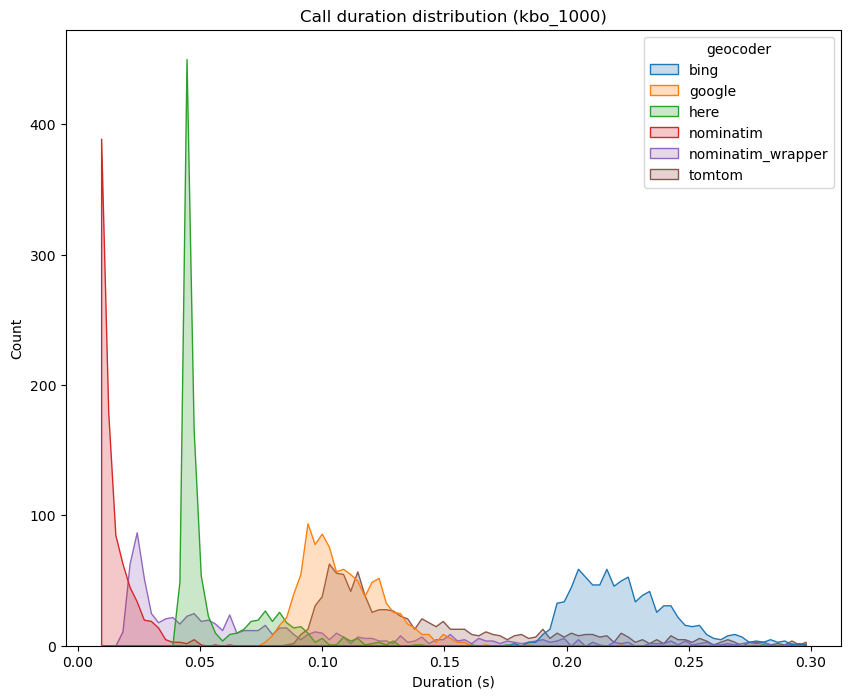

In [42]:
plt.figure(figsize=def_figsize)
sbn.histplot(geocoded_data_duration[geocoded_data_duration.duration<0.3].sort_values("geocoder"), 
             x="duration", hue="geocoder", element="poly",
            bins=100).set(title=f'Call duration distribution ({dataset})', xlabel="Duration (s)")

pdf_savefig()
    

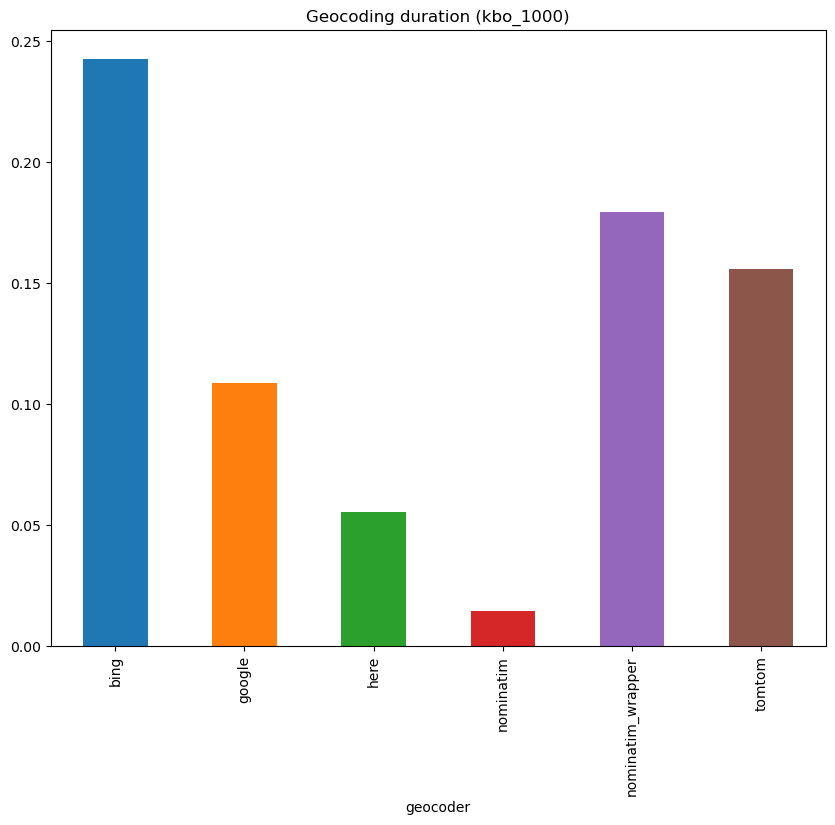

In [43]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

geocoded_data_duration.groupby("geocoder").duration.mean().plot.bar(color=colors, 
                                                                    title=f"Geocoding duration ({dataset})",
                                                                   figsize=def_figsize)
plt.savefig(f'{fig_path}/geocoding_speed.png', dpi=150,  bbox_inches='tight')

pdf_savefig()

<Axes: title={'center': 'Geocoding duration (kbo_1000)'}, xlabel='geocoder'>

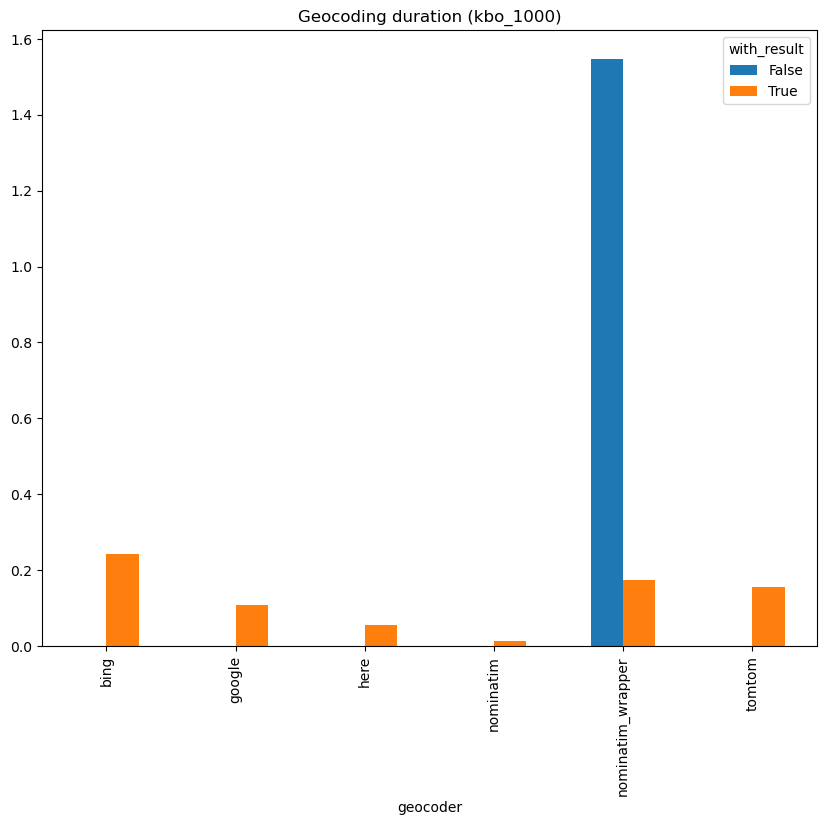

In [44]:
geocoded_data_duration.groupby(["geocoder", "with_result"]).duration.mean().unstack().plot.bar(title=f"Geocoding duration ({dataset})",
                                                                                              figsize=def_figsize)

In [45]:
# geocoded_data_duration[geocoded_data_duration.geocoder=="tomtom"]

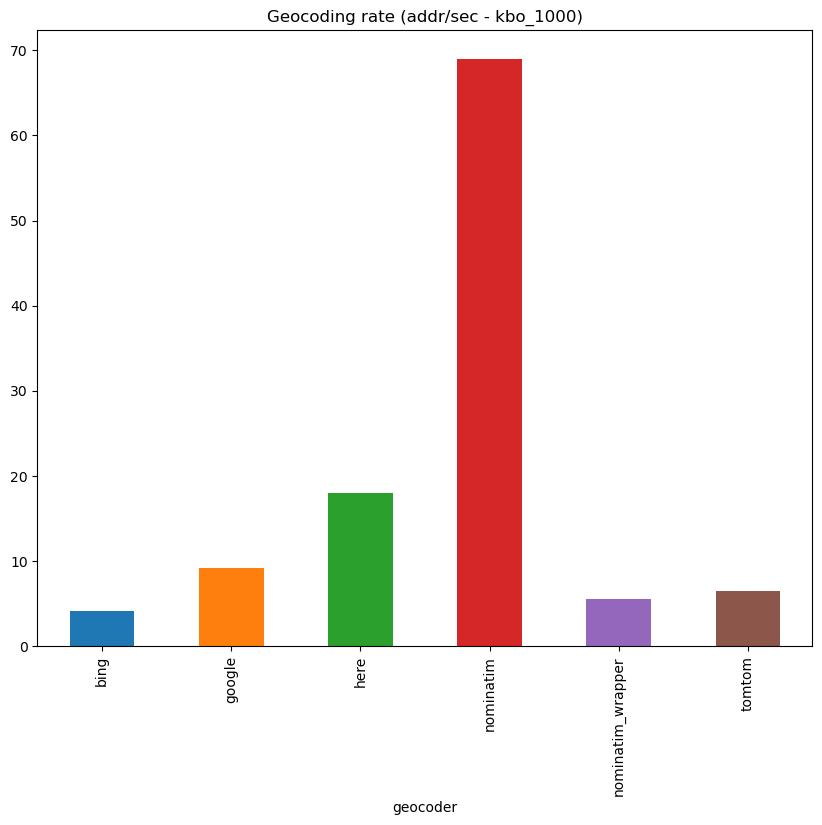

In [46]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

(1/geocoded_data_duration.groupby("geocoder").duration.mean()).plot.bar(color=colors, 
                                                                        title=f"Geocoding rate (addr/sec - {dataset})",
                                                                        figsize=def_figsize)
# plt.savefig(f'{fig_path}/geocoding_speed_rate.png', dpi=150,  bbox_inches='tight')

pdf_savefig()

# Matching rate

## Matching rate

In [47]:
data

reference_key                   street housenumber postcode  \
0                0     Dendermondsesteenweg         200     2830   
1                1      Boulevard du Régent          47     1000   
2                2                 Hauwaart          44     9700   
3                3          Bruynebosstraat          40     3511   
4                4        Steenwinkelstraat         583     2627   
..             ...                      ...         ...      ...   
995            995          Route de Marche          43     6940   
996            996  Godfried van Leuvenlaan           8     1600   
997            997               Valleilaan          83     3290   
998            998              Venusstraat           2     2000   
999            999             Voie Jocquée          10     6830   

                   city                                            address  
0            Willebroek  Dendermondsesteenweg, 200, 2830 Willebroek, Be...  
1             Bruxelles  Boulevard du Régent, 47, 1000 Bruxelles, Belgique  
2            Oudenaarde            Hauwaart, 44, 9700 Oudenaarde, Belgique  
3               Hasselt        Bruynebosstraat, 40, 3511 Hasselt, Belgique  
4               Schelle     Steenwinkelstraat, 583, 2627 Schelle, Belgique  
..                  ...                                                ...  
995              Durbuy         Route de Marche, 43, 6940 Durbuy, Belgique  
996  Sint-Pieters-Leeuw  Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...  
997               Diest               Valleilaan, 83, 3290 Diest, Belgique  
998           Antwerpen           Venusstraat, 2, 2000 Antwerpen, Belgique  
999            Bouillon          Voie Jocquée, 10, 6830 Bouillon, Belgique  

[1000 rows x 6 columns]

In [48]:
mr = (geocoded_data.groupby("geocoder").address.count()/ data.shape[0])

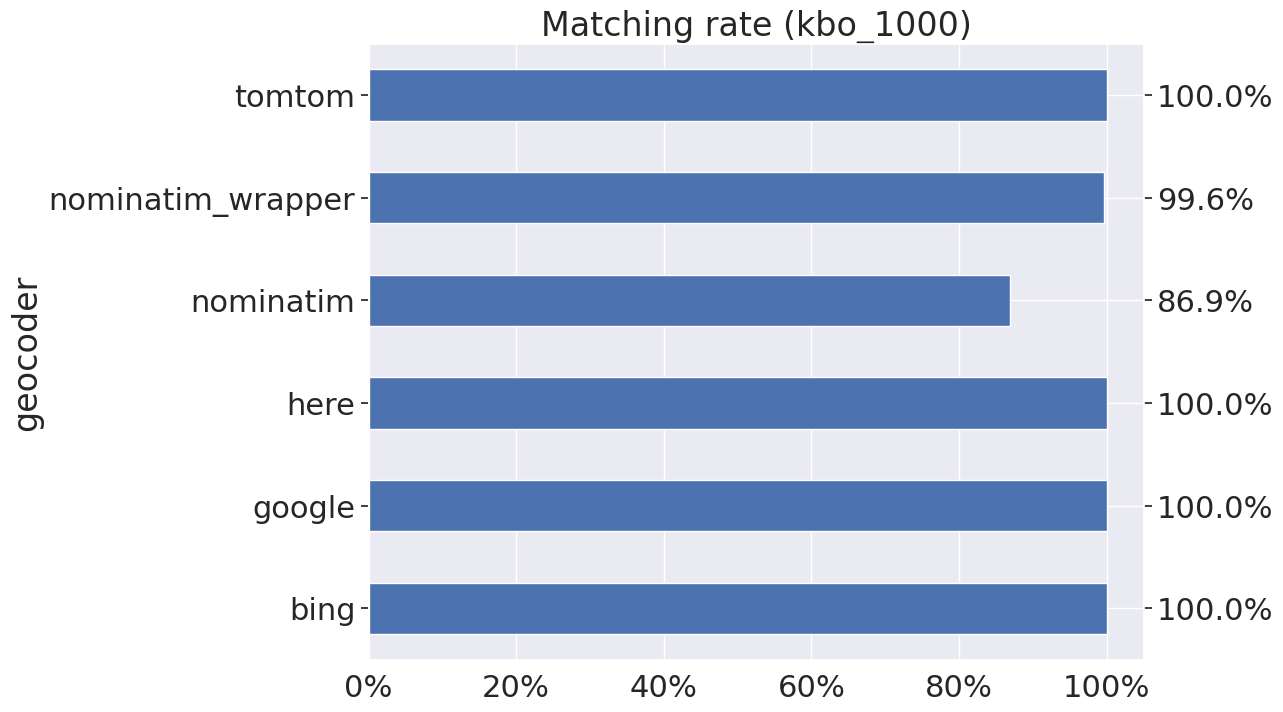

In [49]:
def show_values_on_hbars(ax, values):
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(values.apply("{:.1%}".format))#mr_prec_plot.get_yticklabels())
    # ax2.xaxis.set_major_formatter('')
    ax2.grid(axis='y')   
    
    


plt.figure(figsize=def_figsize)
sbn.set(font_scale=2)

mr_plot=mr.rename("matching rate").plot.barh(title=f"Matching rate ({dataset})")

show_values_on_hbars(mr_plot, mr)


mr_plot.xaxis.set_major_formatter('{x:.0%}')


pdf_savefig()

sbn.set(font_scale=1)



In [50]:
# geocoded_data.groupby("address").geocoder.count().value_counts().sort_index(ascending=False).plot.bar(title="Number of success per address")

## Extract precision

In [51]:
geocoded_data["precision"] = geocoded_data.apply(get_precision, axis=1)

In [52]:
geocoded_data[geocoded_data.precision.str.contains("UNK")][["geocoder" , "precision"]].value_counts()#drop_duplicates()

Series([], dtype: int64)

In [53]:
geocoded_data[geocoded_data.precision.str.contains("UNK")]

Empty DataFrame
Columns: [reference_key, street, housenumber, postcode, city, address, location, geocoder, duration, precision]
Index: []

In [54]:
geocoded_data["precision"] = geocoded_data.precision.replace("^\[UNKNOWN.*\]", "[UNKNOWN]", regex=True)

## Precision

In [55]:
mr

geocoder
bing                 1.000
google               1.000
here                 1.000
nominatim            0.869
nominatim_wrapper    0.996
tomtom               1.000
Name: address, dtype: float64

In [56]:
def plot_matching_rate(geocoded_data, title=f"Matching rate - Precision ({dataset})"):
    sbn.set(font_scale=2)
    mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
    mr_prec = mr_prec/data.shape[0]
    mr_prec = mr_prec.reindex(["building", "street", "city", "country"], axis=1).reindex(coders, axis=0) # , "[UNKNOWN]"

    mr_prec_plot= mr_prec.plot.barh(stacked=True, 
                                    figsize=def_figsize, 
                                    title=title, 
                                    color=["tab:green", "tab:orange", "tab:red", "darkred" , "tab:grey"])
    mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')

    mr_prec_plot.set_ylabel(None)

    plt.legend(loc='lower left')

    show_values_on_hbars(mr_prec_plot, mr.reindex(coders))

    for bars in mr_prec_plot.containers:
        mr_prec_plot.bar_label(bars, label_type="center", fmt=lambda x: "{0:.0%}".format(x) if x >0.005 else "", fontproperties={"size":"x-small"})


    plt.savefig(f'{fig_path}/matching_rate_{dataset}.png', dpi=150,  bbox_inches='tight')

    sbn.set(font_scale=1)
    
    return mr_prec


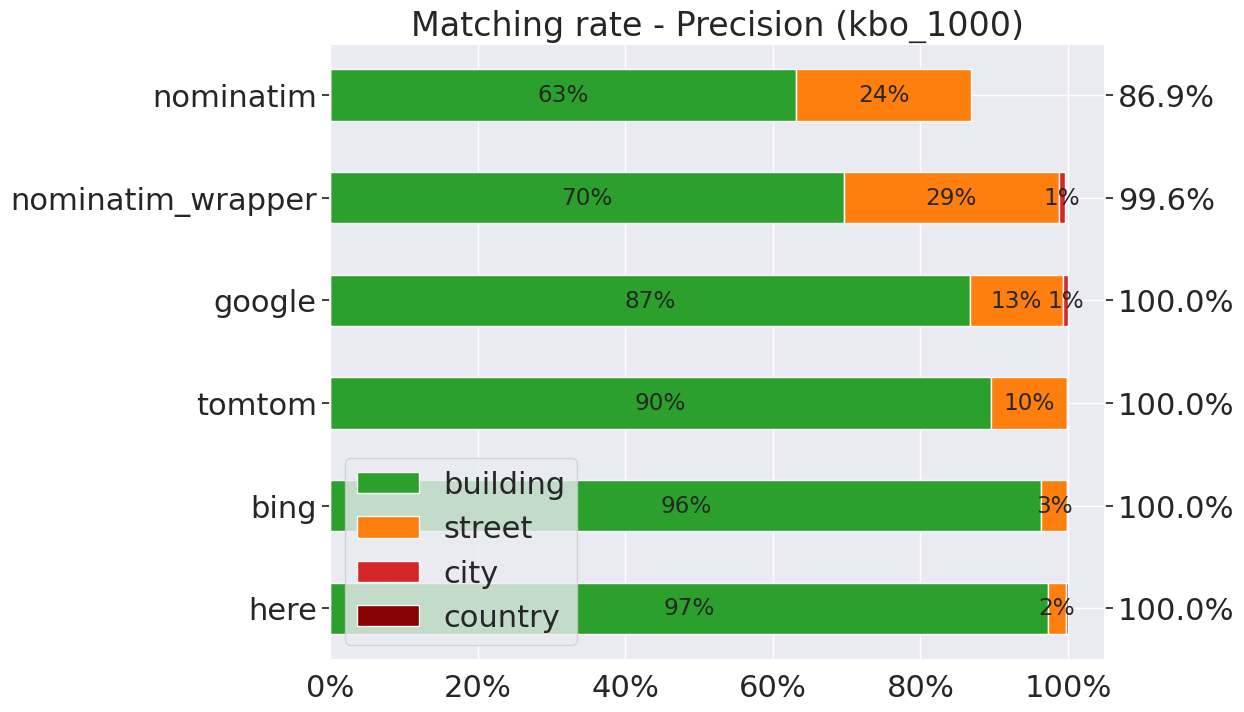

In [57]:
mr_prec = plot_matching_rate(geocoded_data)
pdf_savefig()

In [58]:
# no builing MR (for Nominatim):
# best : 31.6+0.4 = 32 %
# kbo : 24+1 = 25 %
# resto : 13.1 + 4.5 = 17.5 
with pd.option_context('display.float_format', '{:0.1%}'.format):
    display(mr_prec.fillna(""))


precision          building  street city country
geocoder                                        
here                  97.3%    2.4% 0.3%        
bing                  96.4%    3.4% 0.2%        
tomtom                89.5%   10.4% 0.1%        
google                86.7%   12.6% 0.7%        
nominatim_wrapper     69.6%   29.2% 0.8%        
nominatim             63.2%   23.7%

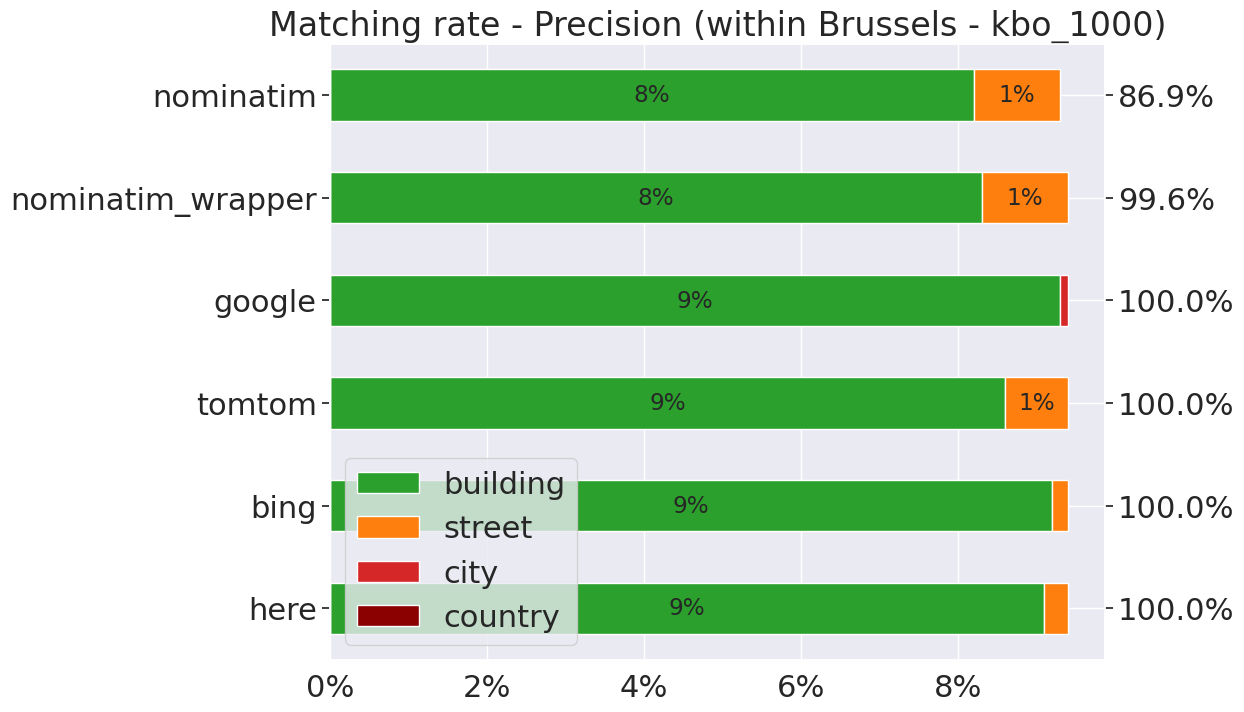

In [59]:
# geocoded_data
addr_in_bru = geocoded_data[geocoded_data.postcode.astype(int).between(1000, 1299)].address
geocoded_data_bru = geocoded_data[geocoded_data.address.isin(addr_in_bru)] 

mr_prec = plot_matching_rate(geocoded_data_bru, f"Matching rate - Precision (within Brussels - {dataset})")
pdf_savefig()

# Distance to median statistics

## Extract location

In [60]:
lat = geocoded_data["location"].apply(lambda loc: loc.point.latitude if loc and loc.point.latitude >0 else None)
lng =  geocoded_data["location"].apply(lambda loc: loc.point.longitude if loc else None)
geocoded_data["point"] = np.where(lat.notnull(), gpd.points_from_xy(lng, lat), pd.NA)

In [61]:
geocoded_data[geocoded_data.point.isnull()]

Empty DataFrame
Columns: [reference_key, street, housenumber, postcode, city, address, location, geocoder, duration, precision, point]
Index: []

<Axes: >

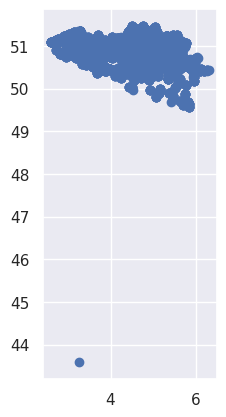

In [62]:
geocoded_data[geocoded_data.point.notnull()].set_geometry("point").plot()

In [63]:
geocoded_data = geocoded_data[geocoded_data.point.notnull()] 

In [64]:
geocoded_data = gpd.GeoDataFrame(geocoded_data).set_geometry("point").set_crs(osm_crs, allow_override=True).to_crs(crs)
geocoded_data

reference_key                   street housenumber postcode  \
0                 0     Dendermondsesteenweg         200     2830   
1                 1      Boulevard du Régent          47     1000   
2                 2                 Hauwaart          44     9700   
3                 3          Bruynebosstraat          40     3511   
4                 4        Steenwinkelstraat         583     2627   
...             ...                      ...         ...      ...   
5995            995          Route de Marche          43     6940   
5996            996  Godfried van Leuvenlaan           8     1600   
5997            997               Valleilaan          83     3290   
5998            998              Venusstraat           2     2000   
5999            999             Voie Jocquée          10     6830   

                    city                                            address  \
0             Willebroek  Dendermondsesteenweg, 200, 2830 Willebroek, Be...   
1              Bruxelles  Boulevard du Régent, 47, 1000 Bruxelles, Belgique   
2             Oudenaarde            Hauwaart, 44, 9700 Oudenaarde, Belgique   
3                Hasselt        Bruynebosstraat, 40, 3511 Hasselt, Belgique   
4                Schelle     Steenwinkelstraat, 583, 2627 Schelle, Belgique   
...                  ...                                                ...   
5995              Durbuy         Route de Marche, 43, 6940 Durbuy, Belgique   
5996  Sint-Pieters-Leeuw  Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...   
5997               Diest               Valleilaan, 83, 3290 Diest, Belgique   
5998           Antwerpen           Venusstraat, 2, 2000 Antwerpen, Belgique   
5999            Bouillon          Voie Jocquée, 10, 6830 Bouillon, Belgique   

                                               location   geocoder  duration  \
0     (Dendermondsesteenweg 200, 2830 Willebroek, Be...       here  0.279315   
1     (Boulevard du Régent 47, 1000 Bruxelles, Belgi...       here  0.051427   
2     (Hauwaart 44, 9700 Oudenaarde, België, Oudenaa...       here  0.043534   
3     (Bruynebosstraat 40, 3511 Hasselt, België, Has...       here  0.043156   
4     (Steenwinkelstraat 583, 2627 Schelle, België, ...       here  0.045378   
...                                                 ...        ...       ...   
5995  (43, Route de Marche, Barvaux, Durbuy, Marche-...  nominatim  0.010100   
5996  (8, Godfried van Leuvenlaan, Klein-Bijgaarden,...  nominatim  0.012078   
5997  (83, Valleilaan, Diest, Leuven, Vlaams-Brabant...  nominatim  0.010409   
5998  (2, Venusstraat, Universiteitsbuurt, Antwerpen...  nominatim  0.011149   
5999  (10, Voie Jocquée, Bouillon, Neufchâteau, Luxe...  nominatim  0.008919   

     precision                           point  
0     building  POINT (483871.317 6631823.569)  
1     building  POINT (486332.591 6594343.048)  
2     building  POINT (407795.577 6591582.510)  
3     building  POINT (586172.816 6617374.811)  
4     building  POINT (486026.463 6643019.604)  
...        ...                             ...  
5995  building  POINT (611105.400 6506694.506)  
5996  building  POINT (477289.412 6586081.235)  
5997  building  POINT (562012.222 6619229.827)  
5998  building  POINT (490813.231 6661165.572)  
5999  building  POINT (564539.840 6410883.792)  

[5865 rows x 11 columns]

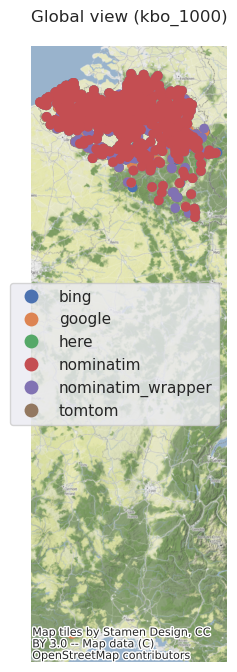

In [65]:
from matplotlib.colors import ListedColormap

colors = ListedColormap([f"C{i}" for i in range(geocoded_data.geocoder.nunique())], name="mycmap")
ax=geocoded_data.plot("geocoder", legend=True, figsize=def_figsize, cmap=colors)
plt.title(f"Global view ({dataset})")
add_basemap(ax)
# img_name=f"{fig_path}/global_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name)
# pdf.add_page()
# pdf.image(f"{fig_path}/global_{dataset}.png", 0, 0, 290)
plt.axis("off")
pdf_savefig()
# plt.show()
# plt.close()

In [66]:
belgium_boundaries = gpd.read_file("data/boundaries.geojson", driver="GeoJSON")
belgium_boundaries = belgium_boundaries[belgium_boundaries.name == "BEL"].geometry.iloc[0].simplify(1000).buffer(1000)
# belgium_boundaries

In [67]:
geocoded_data["is_in_belgium"]= geocoded_data.geometry.within(belgium_boundaries)
geocoded_data["is_in_belgium"].value_counts()

True     5864
False       1
Name: is_in_belgium, dtype: int64

In [68]:
geocoded_data[~geocoded_data.is_in_belgium]

reference_key                      street housenumber postcode  \
3562            562  Rue Emile Vandervelde(PIR)         34+     6240   

            city                                            address  \
3562  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   

                                        location geocoder  duration precision  \
3562  (Hérault, France, (43.5912356, 3.2583626))   google  0.121799      city   

                               point  is_in_belgium  
3562  POINT (362719.265 5402401.329)          False

In [69]:
geocoded_data.groupby("geocoder").is_in_belgium.value_counts()

geocoder           is_in_belgium
bing               True             1000
google             True              999
                   False               1
here               True             1000
nominatim          True              869
nominatim_wrapper  True              996
tomtom             True             1000
Name: is_in_belgium, dtype: int64

In [70]:
geocoded_data[~geocoded_data.is_in_belgium]

reference_key                      street housenumber postcode  \
3562            562  Rue Emile Vandervelde(PIR)         34+     6240   

            city                                            address  \
3562  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   

                                        location geocoder  duration precision  \
3562  (Hérault, France, (43.5912356, 3.2583626))   google  0.121799      city   

                               point  is_in_belgium  
3562  POINT (362719.265 5402401.329)          False

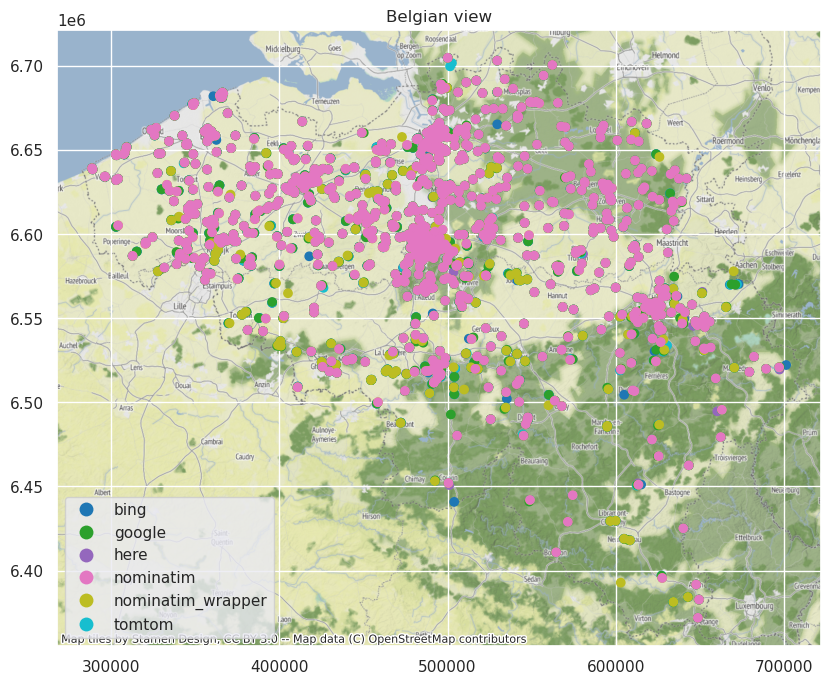

In [71]:
ax=geocoded_data[geocoded_data.is_in_belgium].plot("geocoder", legend=True, figsize=def_figsize)
plt.title("Belgian view")
add_basemap(ax)
pdf_savefig()

## Compute (distance to) median

In [72]:
def get_median_point(bloc):
    bloc = gpd.GeoSeries(bloc.dropna())
    x = np.median(bloc.x)
    y = np.median(bloc.y)
    return shapely.geometry.Point(x, y), bloc.shape[0]
 

In [73]:
# geocoded_data.address.drop_duplicates()

In [74]:
median_geocoders = coders # ["here", "bing", "mapbox", "tomtom", "nominatim_wrapper", "google", "bestaddress"] # Median based on those geocoders
median_points = geocoded_data[geocoded_data.geocoder.isin(median_geocoders)&( geocoded_data.precision=="building") ].groupby("address").point.apply(get_median_point).apply(pd.Series)#.rename("median_point").reset_index()
median_points = median_points.rename(columns={0: "median_point", 1: "nb_points"}).reset_index()
median_points = median_points.set_geometry("median_point").set_crs(geocoded_data.crs)
median_points

address  \
0                   't Pand, 10, 8000 Brugge, Belgique   
1       Aaigembergstraat, 28, 9420 Erpe-Mere, Belgique   
2          Aarschotsebaan, 127, 2590 Berlaar, Belgique   
3       Aarschotsesteenweg, 163, 3010 Leuven, Belgique   
4       Aarschotsesteenweg, 830, 3012 Leuven, Belgique   
..                                                 ...   
983      de Fierlantstraat, 9, 1933 Zaventem, Belgique   
984  de Selliers de Moranvillelaan, 8, 2820 Bonheid...   
985          de Stuersstraat, 20, 8900 Ieper, Belgique   
986                le Roylaan, 3, 2520 Ranst, Belgique   
987  rue Théodore De Cuyper, 121, 1200 Woluwe-Saint...   

                       median_point  nb_points  
0    POINT (359510.812 6657891.196)          6  
1    POINT (437534.708 6600233.701)          6  
2    POINT (519329.754 6636074.644)          6  
3    POINT (524656.107 6605547.648)          3  
4    POINT (526091.508 6609362.428)          6  
..                              ...        ...  
983  POINT (501443.099 6595106.502)          5  
984  POINT (506784.347 6624991.524)          6  
985  POINT (320616.831 6594822.584)          3  
986  POINT (510574.637 6659884.166)          6  
987  POINT (493584.166 6595039.216)          6  

[988 rows x 3 columns]

<Axes: ylabel='nb_points'>

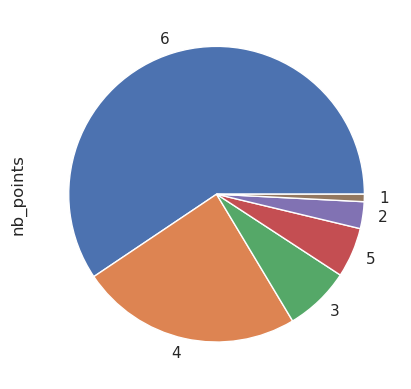

In [75]:
median_points.nb_points.value_counts().plot.pie()

In [76]:
median_points = median_points[median_points.nb_points >= min(3,median_points.nb_points.max()) ]
median_points.shape

(951, 3)

In [77]:
geocoded_data = geocoded_data.merge(median_points, how="left")#.dropna()
# geocoded_data

In [78]:
geocoded_data["dist_to_median"] = geocoded_data.point.distance(geocoded_data.median_point.set_crs(geocoded_data.crs))
geocoded_data.sort_values("dist_to_median")#.tail(100)

reference_key                            street housenumber postcode  \
5864            999                      Voie Jocquée          10     6830   
717             717                    Rue Albert Ier          92     6043   
4491            493                   Drukkerijstraat       11G/H     9240   
2301            301                  Grand Place(AUV)          10     5060   
2290            290            Dokter Van de Perrelei          93     2140   
...             ...                               ...         ...      ...   
5695            801                      Rue d'Abhooz           6     4040   
5702            809  Ch. de la Vieille Chapelle(Ben.)           5     6941   
5721            830                Ijzerenmolenstraat           0     3001   
5733            843               Rue Hautes Golettes         226     5351   
5855            990                         Wirtzfeld         116     4761   

             city                                            address  \
5864     Bouillon          Voie Jocquée, 10, 6830 Bouillon, Belgique   
717     Charleroi       Rue Albert Ier, 92, 6043 Charleroi, Belgique   
4491         Zele        Drukkerijstraat, 11G/H, 9240 Zele, Belgique   
2301  Sambreville   Grand Place(AUV), 10, 5060 Sambreville, Belgique   
2290    Antwerpen  Dokter Van de Perrelei, 93, 2140 Antwerpen, Be...   
...           ...                                                ...   
5695      Herstal            Rue d'Abhooz, 6, 4040 Herstal, Belgique   
5702       Durbuy  Ch. de la Vieille Chapelle(Ben.), 5, 6941 Durb...   
5721       Leuven       Ijzerenmolenstraat, 0, 3001 Leuven, Belgique   
5733         Ohey      Rue Hautes Golettes, 226, 5351 Ohey, Belgique   
5855    Büllingen           Wirtzfeld, 116, 4761 Büllingen, Belgique   

                                               location           geocoder  \
5864  (10, Voie Jocquée, Bouillon, Neufchâteau, Luxe...          nominatim   
717   (Rue Albert Ier 92, 6043 Charleroi, Belgique, ...               here   
4491  (11, Drukkerijstraat, Zele, Dendermonde, Oost-...  nominatim_wrapper   
2301  (Grand Place 10, 5060 Sambreville, (50.44708, ...             tomtom   
2290  (Dokter Van de Perrelei 93, 2140 Antwerpen, (5...             tomtom   
...                                                 ...                ...   
5695  (Rue d'Abhooz, Herstal, Liège, Wallonie, 4040,...          nominatim   
5702  (Chemin de la Vieille Chapelle, Bende, Durbuy,...          nominatim   
5721  (IJzerenmolenstraat, Heverlee, Leuven, Vlaams-...          nominatim   
5733  (Rue Hautes Golettes, Saint-Mort, Haillot, Ohe...          nominatim   
5855  (Wirtzfeld, Büllingen, Verviers, Liège, Wallon...          nominatim   

      duration precision                           point  is_in_belgium  \
5864  0.008919  building  POINT (564539.840 6410883.792)           True   
717   0.045904  building  POINT (498956.222 6526098.597)           True   
4491  0.281921  building  POINT (450872.950 6634478.767)           True   
2301  0.333948  building  POINT (515929.104 6524065.268)           True   
2290  0.241948  building  POINT (495341.678 6658018.283)           True   
...        ...       ...                             ...            ...   
5695  0.010817    street  POINT (625608.926 6567017.030)           True   
5702  0.018210    street  POINT (602949.587 6519584.059)           True   
5721  0.012511    street  POINT (521967.074 6598880.222)           True   
5733  0.011101    street  POINT (572826.945 6525271.621)           True   
5855  0.019155  building  POINT (697072.365 6520800.260)           True   

                        median_point  nb_points  dist_to_median  
5864  POINT (564539.840 6410883.792)        5.0             0.0  
717   POINT (498956.222 6526098.597)        4.0             0.0  
4491  POINT (450872.950 6634478.767)        5.0             0.0  
2301  POINT (515929.104 6524065.268)        3.0             0.0  
2290  POINT (495341.678 6658018.283)

In [79]:
# geocoded_data[geocoded_data.median_point.isnull()].sort_values("address")

In [80]:
# geocoded_data.sort_values("dist_to_median").tail(40).geocoder.value_counts().plot.bar()

In [81]:
def plot_address(geocoded_data, a):
    df = geocoded_data[(geocoded_data.address==a)]
    display(df)
    

    ax = df.assign(label=df.geocoder + " ("+df.dist_to_median.fillna(-1).astype(int).astype(str) + " - " + df.precision + ")").plot(
        "label", 
        legend=True, 
        markersize=100,
            figsize=def_figsize
    )

    if df.dist_to_median.isnull().all():
        print("No median point")
    else: 
        med=df[["median_point"]].drop_duplicates().set_geometry("median_point")
                                                                                                                         
        med.plot(ax=ax, color="red", marker="x", markersize=100)
    ax.set_title(a)
    set_optimal_limits(ax, df)
    add_basemap(ax)
    plt.show()    
    return ax

In [82]:
# plot_address(geocoded_data, geocoded_data.loc[46].address)

reference_key                      street housenumber postcode  \
562             562  Rue Emile Vandervelde(PIR)         34+     6240   
1562            562  Rue Emile Vandervelde(PIR)         34+     6240   
2562            562  Rue Emile Vandervelde(PIR)         34+     6240   
3562            562  Rue Emile Vandervelde(PIR)         34+     6240   
4559            562  Rue Emile Vandervelde(PIR)         34+     6240   

            city                                            address  \
562   Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   
1562  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   
2562  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   
3562  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   
4559  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   

                                               location           geocoder  \
562   (Rue Émile Vandervelde 34, 6240 Farciennes, Be...               here   
1562  (Rue Emile Vandervelde 34, Farciennes, Walloon...               bing   
2562  (Rue Émile Vandervelde 34, 6240 Farciennes, (5...             tomtom   
3562         (Hérault, France, (43.5912356, 3.2583626))             google   
4559  (Rue Émile Vandervelde, Pironchamps, Farcienne...  nominatim_wrapper   

      duration precision                           point  is_in_belgium  \
562   0.128535  building  POINT (504455.404 6520122.419)           True   
1562  0.237390  building  POINT (504455.839 6520123.066)           True   
2562  0.188085  building  POINT (504455.404 6520122.419)           True   
3562  0.121799      city  POINT (362719.265 5402401.329)          False   
4559  0.516747    street  POINT (503642.973 6520833.304)           True   

                        median_point  nb_points  dist_to_median  
562   POINT (504455.404 6520122.419)        3.0    0.000000e+00  
1562  POINT (504455.404 6520122.419)        3.0    7.787468e-01  
2562  POINT (504455.404 6520122.419)        3.0    0.000000e+00  
3562  POINT (504455.404 6520122.419)        3.0    1.126672e+06  
4559  POINT (504455.404 6520122.419)        3.0    1.079538e+03

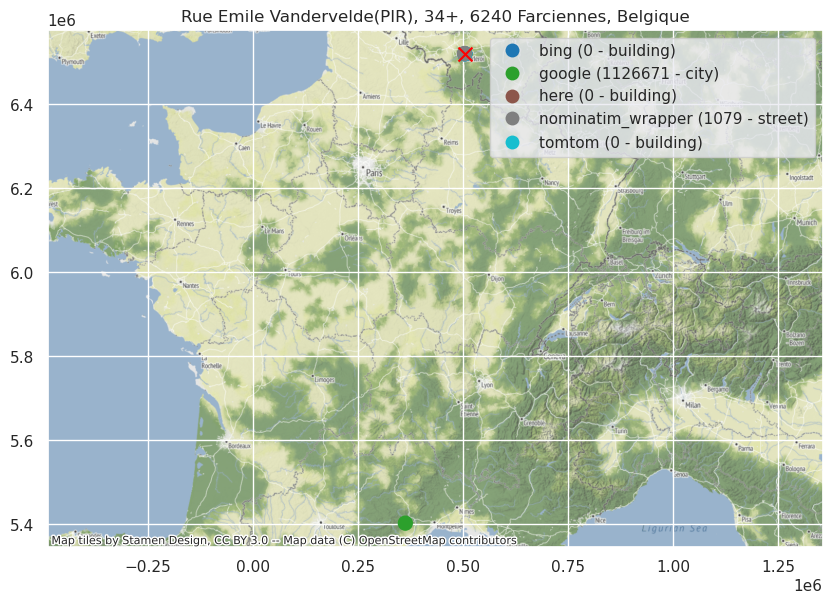

reference_key                 street housenumber postcode   city  \
918             918  Chemin de la Goutaine          6A     6720  Habay   
1918            918  Chemin de la Goutaine          6A     6720  Habay   
2918            918  Chemin de la Goutaine          6A     6720  Habay   
3918            918  Chemin de la Goutaine          6A     6720  Habay   
4915            918  Chemin de la Goutaine          6A     6720  Habay   
5798            918  Chemin de la Goutaine          6A     6720  Habay   

                                              address  \
918   Chemin de la Goutaine, 6A, 6720 Habay, Belgique   
1918  Chemin de la Goutaine, 6A, 6720 Habay, Belgique   
2918  Chemin de la Goutaine, 6A, 6720 Habay, Belgique   
3918  Chemin de la Goutaine, 6A, 6720 Habay, Belgique   
4915  Chemin de la Goutaine, 6A, 6720 Habay, Belgique   
5798  Chemin de la Goutaine, 6A, 6720 Habay, Belgique   

                                               location           geocoder  \
918   (Chemin de la Goutaine 6A, 6723 Habay, Belgiqu...               here   
1918  (Chemin de la Fontaine 6A, Genappe, Walloon Re...               bing   
2918  (Chemin de la Goutaine 6, 6720 Habay, (49.7145...             tomtom   
3918  (Chem. de la Goutaine 6A, 6720 Habay, Belgium,...             google   
4915  (Chemin de la Goutaine, Habay-la-Vieille, Haba...  nominatim_wrapper   
5798  (Chemin de la Goutaine, Habay-la-Vieille, Haba...          nominatim   

      duration precision                           point  is_in_belgium  \
918   0.160780  building  POINT (627170.672 6396935.256)           True   
1918  0.431361  building  POINT (491191.598 6552827.626)           True   
2918  0.224769    street  POINT (627179.577 6396988.626)           True   
3918  0.095241  building  POINT (627170.794 6396934.464)           True   
4915  0.086873    street  POINT (627559.010 6395599.959)           True   
5798  0.018908    street  POINT (627559.010 6395599.959)           True   

                        median_point  nb_points  dist_to_median  
918   POINT (627170.672 6396935.256)        3.0        0.000000  
1918  POINT (627170.672 6396935.256)        3.0   206864.059820  
2918  POINT (627170.672 6396935.256)        3.0       54.108072  
3918  POINT (627170.672 6396935.256)        3.0        0.801353  
4915  POINT (627170.672 6396935.256)        3.0     1390.619904  
5798  POINT (627170.672 6396935.256)        3.0     1390.619904

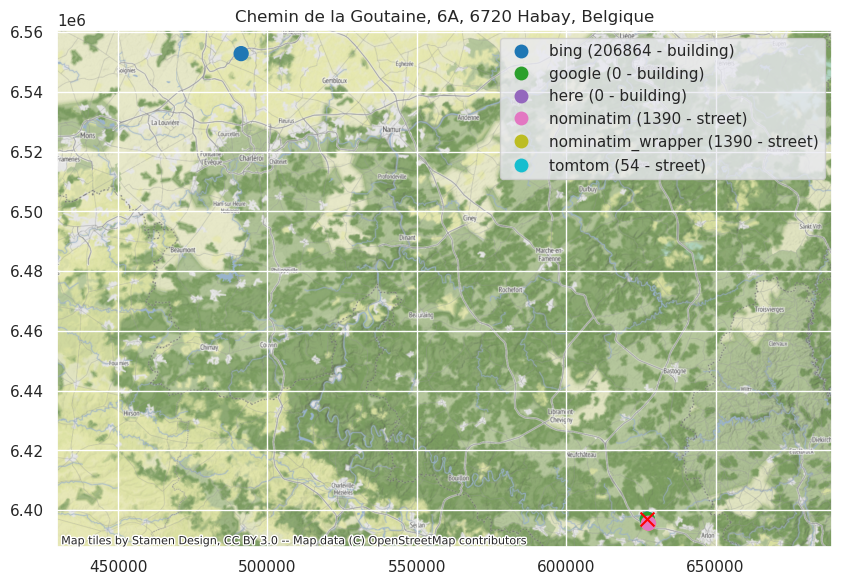

reference_key                street housenumber postcode      city  \
821             821  Rue de la Maladrerie          17     6200  Châtelet   
1821            821  Rue de la Maladrerie          17     6200  Châtelet   
2821            821  Rue de la Maladrerie          17     6200  Châtelet   
3821            821  Rue de la Maladrerie          17     6200  Châtelet   
4818            821  Rue de la Maladrerie          17     6200  Châtelet   

                                                address  \
821   Rue de la Maladrerie, 17, 6200 Châtelet, Belgique   
1821  Rue de la Maladrerie, 17, 6200 Châtelet, Belgique   
2821  Rue de la Maladrerie, 17, 6200 Châtelet, Belgique   
3821  Rue de la Maladrerie, 17, 6200 Châtelet, Belgique   
4818  Rue de la Maladrerie, 17, 6200 Châtelet, Belgique   

                                               location           geocoder  \
821   (Rue de la Maladrerie 17, 6200 Châtelet, Belgi...               here   
1821  (Rue de la Maladrerie 17, Châtelet, Walloon Re...               bing   
2821  (Rue de la Maladrerie 17, 6200 Châtelet, (50.3...             tomtom   
3821  (Rue de la Maladrerie 17, 6200 Châtelet, Belgi...             google   
4818  (17, Rue de la Maladrerie, Jamoigne, Chiny, Vi...  nominatim_wrapper   

      duration precision                           point  is_in_belgium  \
821   0.045333  building  POINT (504061.333 6515168.559)           True   
1821  0.242480  building  POINT (504061.400 6515168.803)           True   
2821  0.247161  building  POINT (504061.333 6515168.559)           True   
3821  0.138151  building  POINT (504066.232 6515175.247)           True   
4818  0.579334  building  POINT (602943.462 6392837.737)           True   

                        median_point  nb_points  dist_to_median  
821   POINT (504061.400 6515168.559)        5.0        0.066792  
1821  POINT (504061.400 6515168.559)        5.0        0.244476  
2821  POINT (504061.400 6515168.559)        5.0        0.066792  
3821  POINT (504061.400 6515168.559)        5.0        8.250612  
4818  POINT (504061.400 6515168.559)        5.0   157297.462966

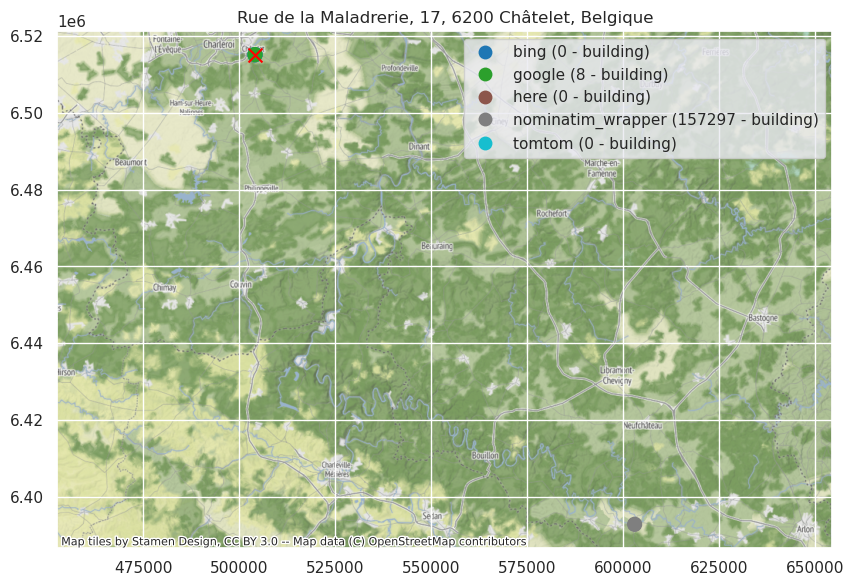

reference_key              street housenumber postcode        city  \
682             682  Vooruitgangsstraat         106     2830  Willebroek   
1682            682  Vooruitgangsstraat         106     2830  Willebroek   
2682            682  Vooruitgangsstraat         106     2830  Willebroek   
3682            682  Vooruitgangsstraat         106     2830  Willebroek   
4679            682  Vooruitgangsstraat         106     2830  Willebroek   
5592            682  Vooruitgangsstraat         106     2830  Willebroek   

                                                address  \
682   Vooruitgangsstraat, 106, 2830 Willebroek, Belg...   
1682  Vooruitgangsstraat, 106, 2830 Willebroek, Belg...   
2682  Vooruitgangsstraat, 106, 2830 Willebroek, Belg...   
3682  Vooruitgangsstraat, 106, 2830 Willebroek, Belg...   
4679  Vooruitgangsstraat, 106, 2830 Willebroek, Belg...   
5592  Vooruitgangsstraat, 106, 2830 Willebroek, Belg...   

                                               location           geocoder  \
682   (Vooruitgangsstraat 106, 2830 Willebroek, Belg...               here   
1682  (Vooruitgangstraat 106, Bruges, Flemish Region...               bing   
2682  (Vooruitgangsstraat 106, 2830 Willebroek, (51....             tomtom   
3682  (Vooruitgangsstraat 106, 2830 Willebroek, Belg...             google   
4679  (Vooruitgangsstraat, Willebroek, Mechelen, Ant...  nominatim_wrapper   
5592  (Vooruitgangsstraat, Willebroek, Mechelen, Ant...          nominatim   

      duration precision                           point  is_in_belgium  \
682   0.058496  building  POINT (485109.190 6631343.600)           True   
1682  0.186339  building  POINT (362583.200 6655960.085)           True   
2682  0.093817  building  POINT (485110.303 6631343.600)           True   
3682  0.098886  building  POINT (485115.179 6631355.182)           True   
4679  0.029857    street  POINT (485424.391 6631338.924)           True   
5592  0.016909    street  POINT (485424.391 6631338.924)           True   

                        median_point  nb_points  dist_to_median  
682   POINT (485109.747 6631349.391)        4.0        5.818031  
1682  POINT (485109.747 6631349.391)        4.0   124973.761375  
2682  POINT (485109.747 6631349.391)        4.0        5.818031  
3682  POINT (485109.747 6631349.391)        4.0        7.940438  
4679  POINT (485109.747 6631349.391)        4.0      314.818588  
5592  POINT (485109.747 6631349.391)        4.0      314.818588

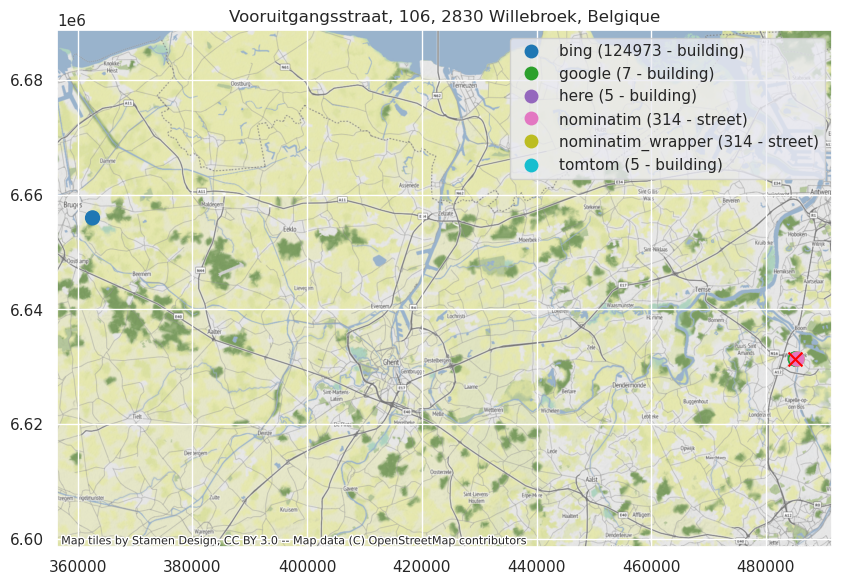

reference_key       street housenumber postcode       city  \
391             391  Jodenstraat      12 b 1     2000  Antwerpen   
1391            391  Jodenstraat      12 b 1     2000  Antwerpen   
2391            391  Jodenstraat      12 b 1     2000  Antwerpen   
3391            391  Jodenstraat      12 b 1     2000  Antwerpen   
4389            391  Jodenstraat      12 b 1     2000  Antwerpen   
5347            391  Jodenstraat      12 b 1     2000  Antwerpen   

                                            address  \
391   Jodenstraat, 12 b 1, 2000 Antwerpen, Belgique   
1391  Jodenstraat, 12 b 1, 2000 Antwerpen, Belgique   
2391  Jodenstraat, 12 b 1, 2000 Antwerpen, Belgique   
3391  Jodenstraat, 12 b 1, 2000 Antwerpen, Belgique   
4389  Jodenstraat, 12 b 1, 2000 Antwerpen, Belgique   
5347  Jodenstraat, 12 b 1, 2000 Antwerpen, Belgique   

                                               location           geocoder  \
391   (Jodenstraat 12B, 2000 Antwerpen, België, Antw...               here   
1391  (Jodenstraat 12 Box 1, Antwerpen, Région flama...               bing   
2391  (Jodenstraat 12, 2000 Antwerpen, (51.21676, 4....             tomtom   
3391  (Jodenstraat 12B/1, 2000 Antwerpen, Belgium, (...             google   
4389  (Jodenstraat, Wilde Zee, Antwerpen, Vlaanderen...  nominatim_wrapper   
5347  (Jodenstraat, Wilde Zee, Antwerpen, Vlaanderen...          nominatim   

      duration precision                           point  is_in_belgium  \
391   0.086291  building  POINT (490567.185 6659738.434)           True   
1391  0.275748  building  POINT (529551.716 6665217.073)           True   
2391  0.295755  building  POINT (490539.355 6659725.993)           True   
3391  0.133328  building  POINT (490558.212 6659766.532)           True   
4389  0.312302    street  POINT (490471.906 6659758.801)           True   
5347  0.019425    street  POINT (490471.906 6659758.801)           True   

                        median_point  nb_points  dist_to_median  
391   POINT (490562.699 6659752.483)        4.0       14.747705  
1391  POINT (490562.699 6659752.483)        4.0    39370.105402  
2391  POINT (490562.699 6659752.483)        4.0       35.307319  
3391  POINT (490562.699 6659752.483)        4.0       14.747705  
4389  POINT (490562.699 6659752.483)        4.0       91.011735  
5347  POINT (490562.699 6659752.483)        4.0       91.011735

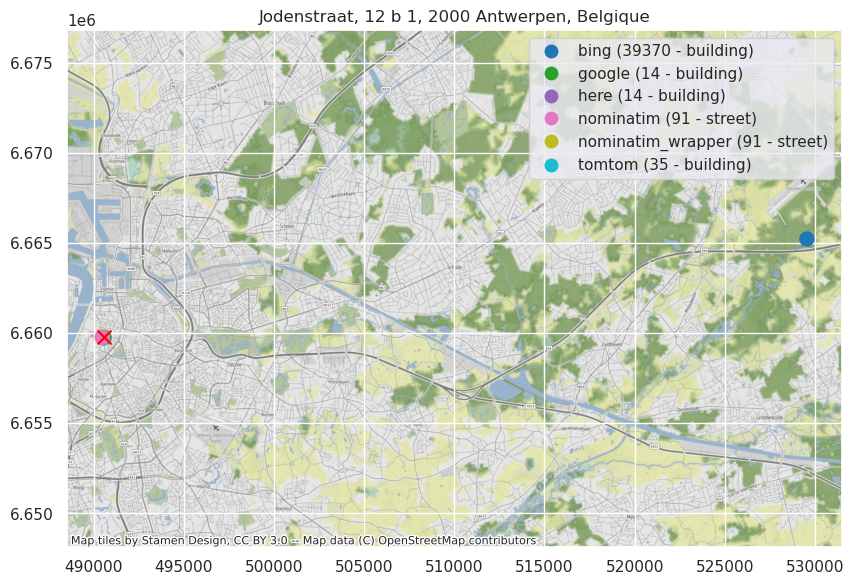

In [83]:
for a in geocoded_data.sort_values("dist_to_median", ascending=False).address.unique()[0:5]:
    #print(a)
    plot_address(geocoded_data, a)
   

## Median pertinence

How many close to median ?

In [84]:
nb_close_to_median = geocoded_data.assign(close_to_median = geocoded_data.dist_to_median < 100).groupby("address").close_to_median.sum()
nb_close_to_median

address
't Pand, 10, 8000 Brugge, Belgique                                  6
Aaigembergstraat, 28, 9420 Erpe-Mere, Belgique                      6
Aarschotsebaan, 127, 2590 Berlaar, Belgique                         6
Aarschotsesteenweg, 163, 3010 Leuven, Belgique                      4
Aarschotsesteenweg, 830, 3012 Leuven, Belgique                      6
                                                                   ..
de Fierlantstraat, 9, 1933 Zaventem, Belgique                       4
de Selliers de Moranvillelaan, 8, 2820 Bonheiden, Belgique          6
de Stuersstraat, 20, 8900 Ieper, Belgique                           4
le Roylaan, 3, 2520 Ranst, Belgique                                 6
rue Théodore De Cuyper, 121, 1200 Woluwe-Saint-Lambert, Belgique    6
Name: close_to_median, Length: 1000, dtype: int64

In [85]:
median_points = median_points.merge(nb_close_to_median.rename("nb_close_to_median").reset_index())

In [86]:
median_points.nb_close_to_median.value_counts()

6    598
4    205
5     80
3     53
2      8
1      5
0      2
Name: nb_close_to_median, dtype: int64

In [87]:
median_points[median_points.nb_close_to_median>=2]

address  \
0                   't Pand, 10, 8000 Brugge, Belgique   
1       Aaigembergstraat, 28, 9420 Erpe-Mere, Belgique   
2          Aarschotsebaan, 127, 2590 Berlaar, Belgique   
3       Aarschotsesteenweg, 163, 3010 Leuven, Belgique   
4       Aarschotsesteenweg, 830, 3012 Leuven, Belgique   
..                                                 ...   
946      de Fierlantstraat, 9, 1933 Zaventem, Belgique   
947  de Selliers de Moranvillelaan, 8, 2820 Bonheid...   
948          de Stuersstraat, 20, 8900 Ieper, Belgique   
949                le Roylaan, 3, 2520 Ranst, Belgique   
950  rue Théodore De Cuyper, 121, 1200 Woluwe-Saint...   

                       median_point  nb_points  nb_close_to_median  
0    POINT (359510.812 6657891.196)          6                   6  
1    POINT (437534.708 6600233.701)          6                   6  
2    POINT (519329.754 6636074.644)          6                   6  
3    POINT (524656.107 6605547.648)          3                   4  
4    POINT (526091.508 6609362.428)          6                   6  
..                              ...        ...                 ...  
946  POINT (501443.099 6595106.502)          5                   4  
947  POINT (506784.347 6624991.524)          6                   6  
948  POINT (320616.831 6594822.584)          3                   4  
949  POINT (510574.637 6659884.166)          6                   6  
950  POINT (493584.166 6595039.216)          6                   6  

[944 rows x 4 columns]

In [88]:
# nb_close_to_median.value_counts()

In [89]:
geocoded_data = geocoded_data.merge(median_points, how="left")

In [90]:
geocoded_data.loc[geocoded_data.nb_close_to_median <2, "dist_to_median"] = pd.NA

In [91]:
geocoded_data[geocoded_data.dist_to_median.notnull()].address.nunique()

944

In [92]:
for a in nb_close_to_median[nb_close_to_median==0].iloc[0:4].index:
    if geocoded_data[geocoded_data.address == a].median_point.notnull().any():
        plot_address(geocoded_data[geocoded_data.median_point.notnull()], a)

## Add selectors

In [93]:
geocoded_data["has_median"] = geocoded_data.dist_to_median.notnull()
geocoded_data["has_median"].value_counts()

True     5556
False     309
Name: has_median, dtype: int64

In [94]:
geocoded_data[geocoded_data["has_median"]].address.nunique()

944

In [95]:
# geocoded_data["is_median_reliable"] =   geocoded_data["nb_close_to_median"]>=2
# geocoded_data.is_median_reliable.value_counts()

In [96]:
# geocoded_data["is_value_normal"]    = geocoded_data.dist_to_median < geocoded_data.dist_to_median.quantile(0.995)
# geocoded_data.is_value_normal.value_counts() # / geocoded_data.shape[0]

In [97]:
# geocoded_data["less_than_10km"]    = geocoded_data.dist_to_median < 10000
# geocoded_data.less_than_10km.value_counts() # / geocoded_data.shape[0]

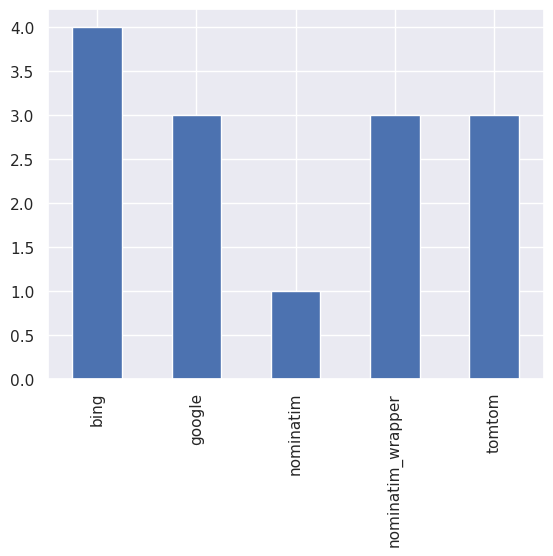

In [98]:
vc = geocoded_data[(geocoded_data.dist_to_median > 10000)].geocoder.value_counts().sort_index()
if vc.shape[0]>0:
    vc.plot.bar()

In [99]:
# geocoded_data.dist_to_median.quantile(0.99)

In [100]:
# pd.crosstab(geocoded_data.is_value_normal, geocoded_data.is_in_belgium)

## Distance to median

### Average

geocoder
bing                  468.185849
google               1317.709115
here                   20.857377
nominatim             196.545389
nominatim_wrapper     416.908400
tomtom                 74.875263
Name: dist_to_median, dtype: float64

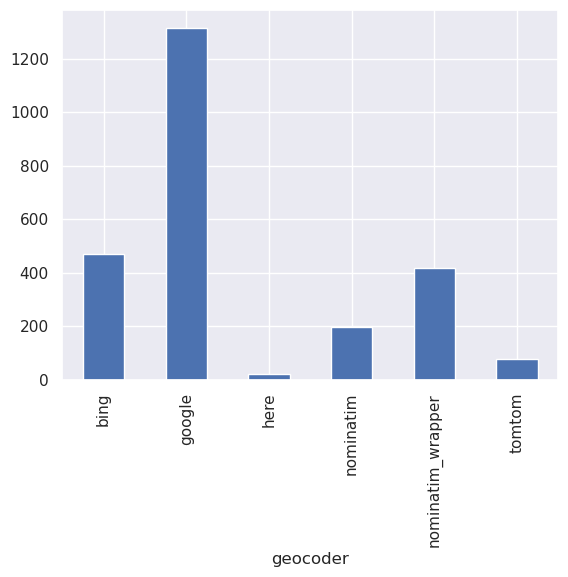

In [101]:
# d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_{dataset}.png")
d2m

geocoder
bing                 468.185849
google               124.332454
here                  20.857377
nominatim            196.545389
nominatim_wrapper    416.908400
tomtom                74.875263
Name: dist_to_median, dtype: float64

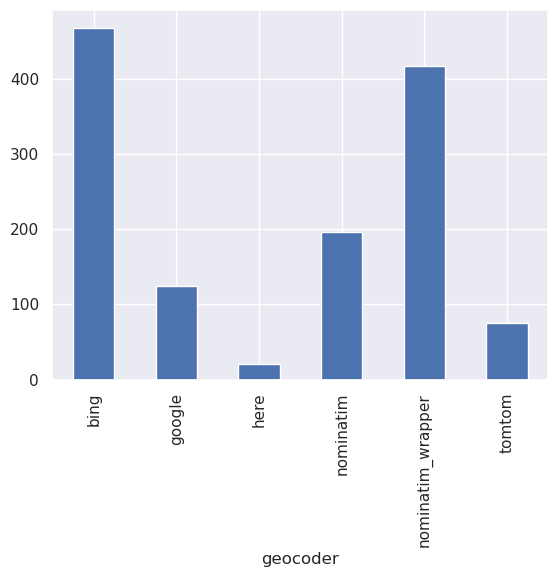

In [102]:
# skipping non reliable median

# d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data[geocoded_data.is_in_belgium].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

### Percentiles

In [103]:
#[geocoded_data.precision=="building"]#.drop_duplicates(subset="address")
# from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import LogLocator
def dist_to_median_line_plot(d, ax=None, title=None, legend=True):
    mean = d.groupby("geocoder").dist_to_median.mean().rename("Mean")

    perc_90 = d.groupby("geocoder").dist_to_median.quantile(0.90).rename("Perc 90%")
    perc_95 = d.groupby("geocoder").dist_to_median.quantile(0.95).rename("Perc 95%")
    perc_99 = d.groupby("geocoder").dist_to_median.quantile(0.99).rename("Perc 99%")
    perc_50 = d.groupby("geocoder").dist_to_median.quantile(0.50).rename("Median")
    maxd = d.groupby("geocoder").dist_to_median.max().rename("Max")
    tops = [ d.groupby("geocoder").dist_to_median.nlargest(i).reset_index().groupby("geocoder").dist_to_median.min() for i in range(2, 50)]#.drop_index(level=1)#@@.tail(1)#.unstack()
#     mean    = mean.sort_values()
#     perc_90 = perc_90.reindex_like(mean)
#     perc_99 = perc_99.reindex_like(mean)
#     perc_50 = perc_50.reindex_like(mean)
#     maxd =    maxd.reindex_like(mean)

    mean    = mean.reindex(coders)
#     perc_90 = perc_90.reindex(coders)
    perc_95 = perc_95.reindex(coders)
    perc_50 = perc_50.reindex(coders)
    maxd =    maxd.reindex(coders)
    tops =    [t.reindex(coders) for t in tops]

    display(mean)
    ax = mean.plot(legend=legend, linestyle='dotted',marker='s', ax=ax, title=title, figsize=def_figsize)
    ax = perc_50.plot(ax=ax, legend=legend,linestyle='dotted', marker='<')
    # ax = perc_90.rename("Perc 90%").plot(ax=ax, legend=True, linestyle='dotted', marker='o')
    ax = perc_95.plot(ax=ax, legend=legend, linestyle='dotted', marker='P')
    # ax = perc_99.rename("Perc 99%").plot(ax=ax, legend=True, linestyle='dotted', marker='P')
    ax = maxd.plot(ax=ax, rot=90, legend=legend, linestyle='dotted',marker='^', logy=True)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    for t in tops:
        t.plot(ax=ax, rot=90, legend=False, linestyle="", marker='.', logy=True, c='grey', zorder=1)
    ax.set_ylabel(f"Distance to median point ({dataset})")
#     ax.set_yscale("log")
#     ax.spines['left'].set_color('red')
#     plt.tick_params(axis='y', which='minor')
#     ax.tick_params(axis='y', colors='red')
#     ax.minorticks_on()
    ax.tick_params(axis="both", direction="out", which="both", left=True, top=False)
#     ax.yaxis.set_minor_locator(LogLocator(5))
#     ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    ax.set_xlabel(None)
    display(pd.DataFrame([mean, perc_50, perc_95, maxd]))
    


geocoder
here                   20.857377
bing                  468.185849
tomtom                 74.875263
google               1317.709115
nominatim_wrapper     416.908400
nominatim             196.545389
Name: Mean, dtype: float64

geocoder         here           bing        tomtom        google  \
Mean        20.857377     468.185849     74.875263  1.317709e+03   
Median       0.875168       0.724887      0.840500  7.357129e+00   
Perc 95%    39.827260      46.681116     57.895184  4.490278e+02   
Max       4186.492840  206864.059820  18393.248201  1.126672e+06   

geocoder  nominatim_wrapper     nominatim  
Mean             416.908400    196.545389  
Median             3.156362      2.849169  
Perc 95%        1109.861462    938.490882  
Max           157297.462966  29771.801128

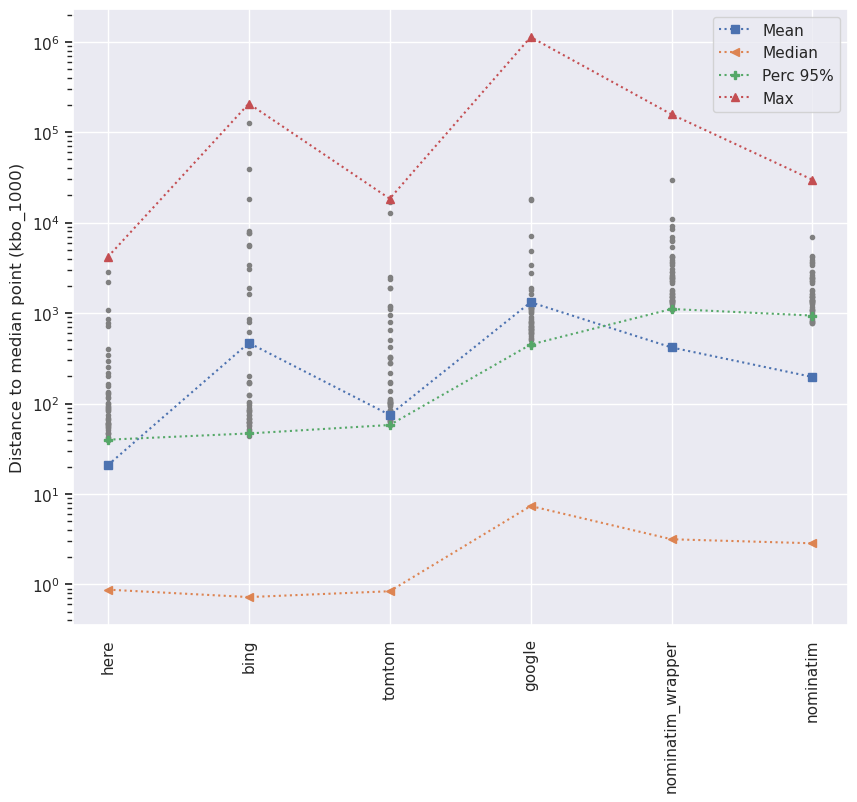

In [104]:
dist_to_median_line_plot(geocoded_data)

pdf_savefig()


geocoder
here                   20.857377
bing                  468.185849
tomtom                 74.875263
google               1317.709115
nominatim_wrapper     416.908400
nominatim             196.545389
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder         here           bing        tomtom        google  \
Mean        20.857377     468.185849     74.875263  1.317709e+03   
Median       0.875168       0.724887      0.840500  7.357129e+00   
Perc 95%    39.827260      46.681116     57.895184  4.490278e+02   
Max       4186.492840  206864.059820  18393.248201  1.126672e+06   

geocoder  nominatim_wrapper     nominatim  
Mean             416.908400    196.545389  
Median             3.156362      2.849169  
Perc 95%        1109.861462    938.490882  
Max           157297.462966  29771.801128

geocoder
here                  20.976879
bing                  93.340458
tomtom                75.593520
google                76.572806
nominatim_wrapper    202.543610
nominatim            162.190124
Name: Mean, dtype: float64

geocoder         here          bing        tomtom       google  \
Mean        20.976879     93.340458     75.593520    76.572806   
Median       0.876916      0.714347      0.838913     7.441283   
Perc 95%    39.793680     42.669077     57.626049   421.296864   
Max       4186.492840  39370.105402  18393.248201  4873.902581   

geocoder  nominatim_wrapper    nominatim  
Mean             202.543610   162.190124  
Median             3.092846     2.784971  
Perc 95%        1085.416611   906.396933  
Max            10974.836484  6892.537367

geocoder
bing                 0.980000
google               0.973000
here                 0.990000
nominatim            0.964327
nominatim_wrapper    0.961847
tomtom               0.990000
Name: reference_key, dtype: float64

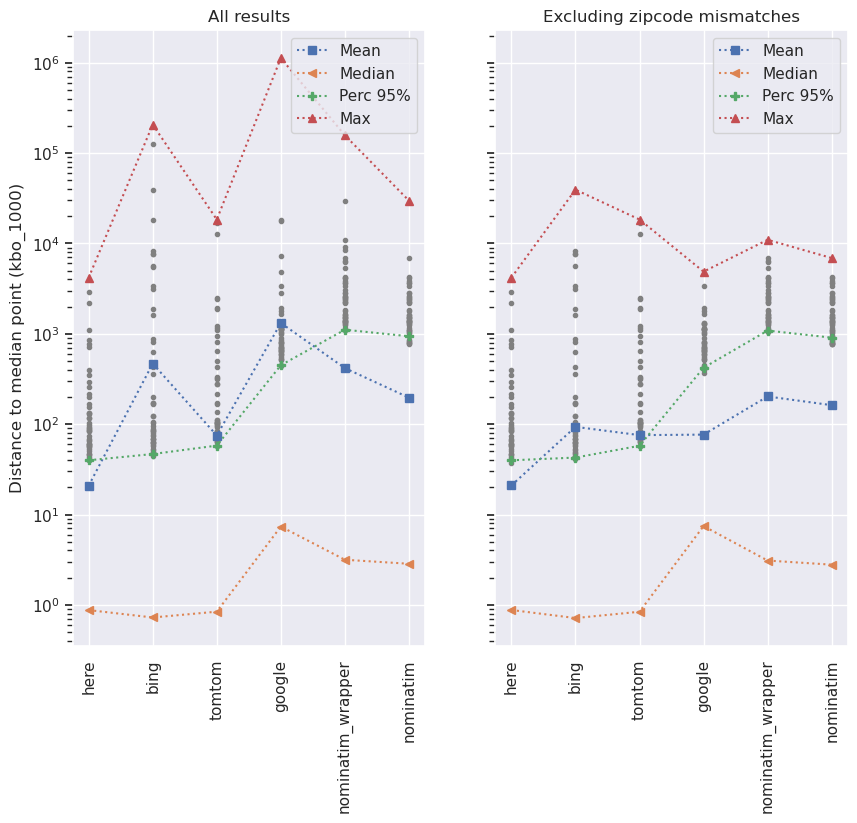

In [105]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.apply(lambda rec: str(rec.postcode) in  str(rec.location.raw), axis=1)]

dist_to_median_line_plot(d, ax[1], "Excluding zipcode mismatches", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

geocoder
here                   20.857377
bing                  468.185849
tomtom                 74.875263
google               1317.709115
nominatim_wrapper     416.908400
nominatim             196.545389
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder         here           bing        tomtom        google  \
Mean        20.857377     468.185849     74.875263  1.317709e+03   
Median       0.875168       0.724887      0.840500  7.357129e+00   
Perc 95%    39.827260      46.681116     57.895184  4.490278e+02   
Max       4186.492840  206864.059820  18393.248201  1.126672e+06   

geocoder  nominatim_wrapper     nominatim  
Mean             416.908400    196.545389  
Median             3.156362      2.849169  
Perc 95%        1109.861462    938.490882  
Max           157297.462966  29771.801128

geocoder
here                  20.857377
bing                 468.185849
tomtom                74.875263
google               124.332454
nominatim_wrapper    416.908400
nominatim            196.545389
Name: Mean, dtype: float64

geocoder         here           bing        tomtom        google  \
Mean        20.857377     468.185849     74.875263    124.332454   
Median       0.875168       0.724887      0.840500      7.352270   
Perc 95%    39.827260      46.681116     57.895184    444.111184   
Max       4186.492840  206864.059820  18393.248201  18213.092467   

geocoder  nominatim_wrapper     nominatim  
Mean             416.908400    196.545389  
Median             3.156362      2.849169  
Perc 95%        1109.861462    938.490882  
Max           157297.462966  29771.801128

geocoder
bing                 1.000
google               0.999
here                 1.000
nominatim            1.000
nominatim_wrapper    1.000
tomtom               1.000
Name: reference_key, dtype: float64

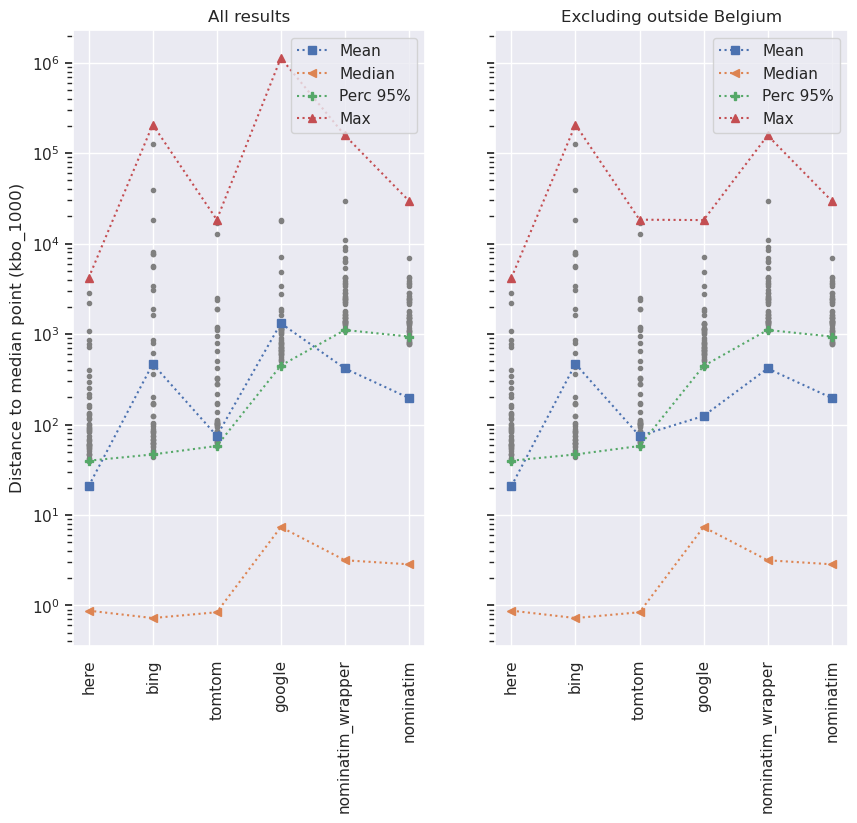

In [106]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.is_in_belgium]

dist_to_median_line_plot(d, ax[1], "Excluding outside Belgium", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

geocoder
here                   20.857377
bing                  468.185849
tomtom                 74.875263
google               1317.709115
nominatim_wrapper     416.908400
nominatim             196.545389
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder         here           bing        tomtom        google  \
Mean        20.857377     468.185849     74.875263  1.317709e+03   
Median       0.875168       0.724887      0.840500  7.357129e+00   
Perc 95%    39.827260      46.681116     57.895184  4.490278e+02   
Max       4186.492840  206864.059820  18393.248201  1.126672e+06   

geocoder  nominatim_wrapper     nominatim  
Mean             416.908400    196.545389  
Median             3.156362      2.849169  
Perc 95%        1109.861462    938.490882  
Max           157297.462966  29771.801128

geocoder
here                  18.564147
bing                 468.185849
tomtom                74.875263
google               112.075381
nominatim_wrapper    403.071525
nominatim            196.545389
Name: Mean, dtype: float64

geocoder         here           bing        tomtom        google  \
Mean        18.564147     468.185849     74.875263    112.075381   
Median       0.873421       0.724887      0.840500      7.308605   
Perc 95%    39.560236      46.681116     57.895184    422.485380   
Max       4186.492840  206864.059820  18393.248201  18213.092467   

geocoder  nominatim_wrapper     nominatim  
Mean             403.071525    196.545389  
Median             3.155492      2.849169  
Perc 95%        1090.388410    938.490882  
Max           157297.462966  29771.801128

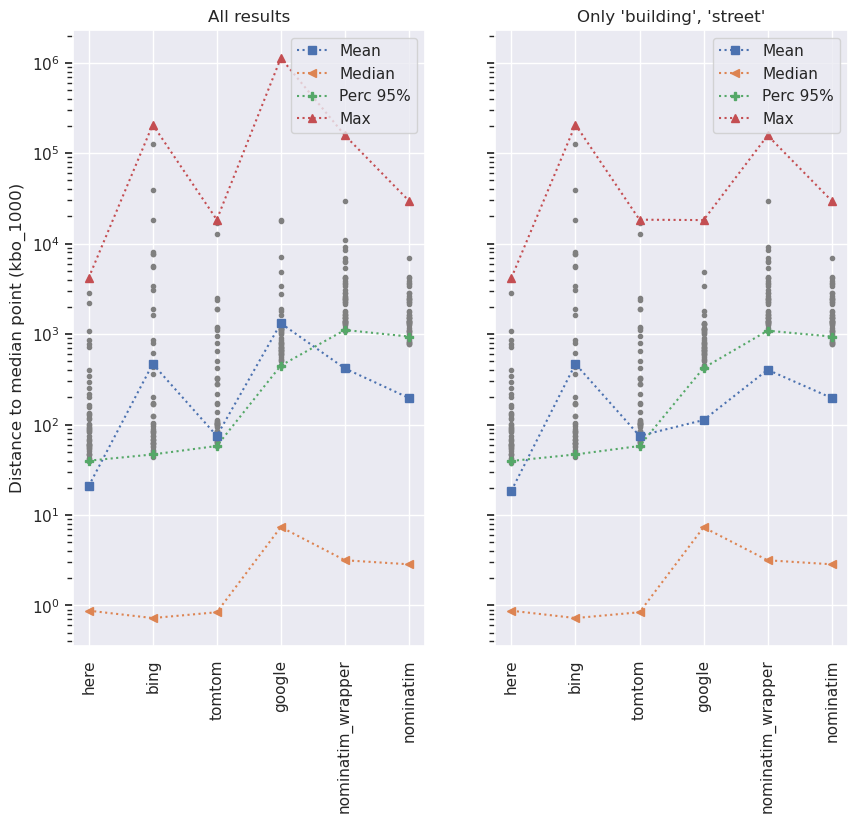

In [107]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.precision.isin(["building", 'street'])]

dist_to_median_line_plot(d, ax[1], "Only 'building', 'street'")

pdf_savefig()


geocoder
here                   20.857377
bing                  468.185849
tomtom                 74.875263
google               1317.709115
nominatim_wrapper     416.908400
nominatim             196.545389
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder         here           bing        tomtom        google  \
Mean        20.857377     468.185849     74.875263  1.317709e+03   
Median       0.875168       0.724887      0.840500  7.357129e+00   
Perc 95%    39.827260      46.681116     57.895184  4.490278e+02   
Max       4186.492840  206864.059820  18393.248201  1.126672e+06   

geocoder  nominatim_wrapper     nominatim  
Mean             416.908400    196.545389  
Median             3.156362      2.849169  
Perc 95%        1109.861462    938.490882  
Max           157297.462966  29771.801128

geocoder
here                  18.661680
bing                  93.340458
tomtom                75.593520
google                74.573321
nominatim_wrapper    186.794045
nominatim            162.190124
Name: Mean, dtype: float64

geocoder         here          bing        tomtom       google  \
Mean        18.661680     93.340458     75.593520    74.573321   
Median       0.875168      0.714347      0.838913     7.406313   
Perc 95%    38.377036     42.669077     57.626049   404.439411   
Max       4186.492840  39370.105402  18393.248201  4873.902581   

geocoder  nominatim_wrapper    nominatim  
Mean             186.794045   162.190124  
Median             3.061649     2.784971  
Perc 95%        1072.909826   906.396933  
Max             6892.537367  6892.537367

geocoder
bing                 0.978000
google               0.969000
here                 0.987000
nominatim            0.964327
nominatim_wrapper    0.954819
tomtom               0.989000
Name: reference_key, dtype: float64

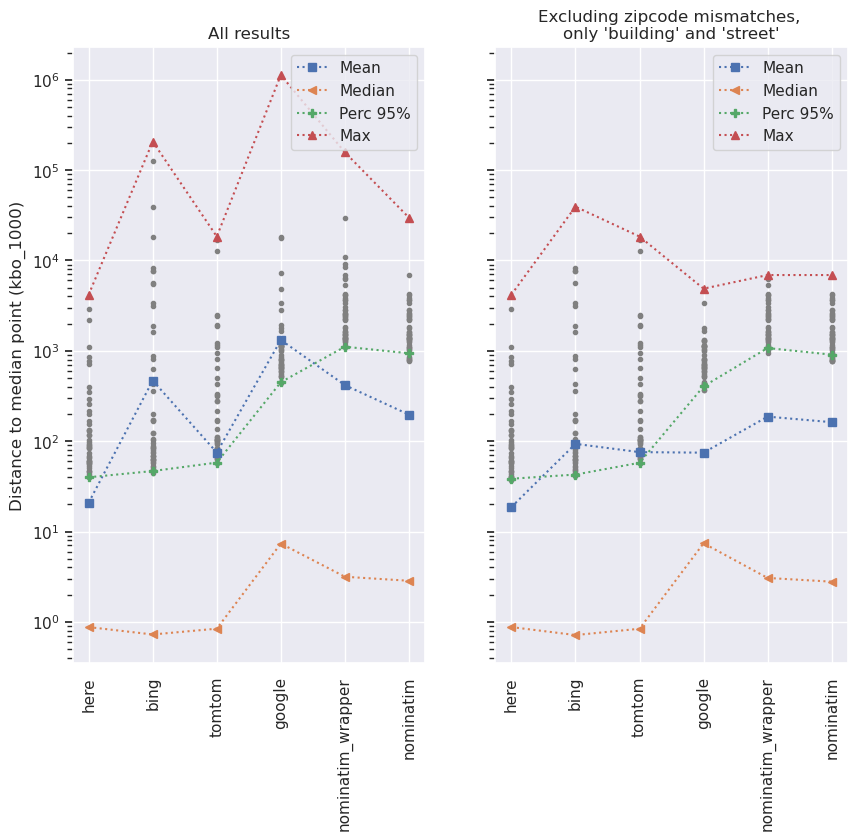

In [108]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.precision.isin(["building", 'street']) & geocoded_data.apply(lambda rec: str(rec.postcode) in  str(rec.location.raw), axis=1)]

dist_to_median_line_plot(d, ax[1], "Excluding zipcode mismatches, \nonly 'building' and 'street'", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

In [109]:
# geocoded_data[~geocoded_data.apply(lambda rec: str(rec.postcode) in  str(rec.location.raw), axis=1)]

In [110]:
pdf.close()